# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/CVAE_ex4/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

0         1         2         3         4         5         6     \
0     0.141376  0.126192  0.160170  0.039393  0.116594  0.244344  0.364260   
1     0.139377  0.119569  0.153211  0.039412  0.117448  0.268657  0.362977   
2     0.163800  0.184355  0.172159  0.027273  0.110422  0.169510  0.386510   
3     0.143226  0.131679  0.156749  0.038878  0.115537  0.241695  0.368068   
4     0.137737  0.123774  0.149359  0.042918  0.111843  0.259588  0.368717   
...        ...       ...       ...       ...       ...       ...       ...   
6013  0.116490  0.110039  0.161647  0.043416  0.096190  0.239978  0.371168   
6014  0.125852  0.120752  0.164564  0.039160  0.104617  0.234347  0.369856   
6015  0.107534  0.116570  0.173803  0.039604  0.088328  0.213753  0.390930   
6016  0.123527  0.140547  0.164611  0.038327  0.096956  0.192954  0.382039   
6017  0.118789  0.118466  0.158106  0.043782  0.097575  0.229872  0.372959   

          7         8         9     ...      3062      3063      3064  3065  \
0     0.179045  0.304383  0.316418  ...  0.000000  0.000000  0.000000   0.0   
1     0.172853  0.304429  0.321536  ...  0.000558  0.000000  0.000185   0.0   
2     0.206604  0.313434  0.314130  ...  0.011560  0.000000  0.000000   0.0   
3     0.185738  0.308175  0.316420  ...  0.000000  0.000457  0.000000   0.0   
4     0.180469  0.305680  0.309504  ...  0.000000  0.000000  0.000000   0.0   
...        ...       ...       ...  ...       ...       ...       ...   ...   
6013  0.168759  0.329152  0.293912  ...  0.000000  0.000000  0.000000   0.0   
6014  0.180599  0.320280  0.302117  ...  0.001283  0.000000  0.000000   0.0   
6015  0.170922  0.355653  0.284926  ...  0.000713  0.026625  0.000000   0.0   
6016  0.200973  0.332633  0.290760  ...  0.002548  0.011003  0.000000   0.0   
6017  0.169601  0.332104  0.290355  ...  0.000000  0.001279  0.000000   0.0   

          3066  3067  3068  3069      3070      3071  
0     0.011685   0.0   0.0   0.0  0.001349  0.024873  
1     0.019411   0.0   0.0   0.0  0.010698  0.031158  
2     0.038945   0.0   0.0   0.0  0.000000  0.005341  
3     0.005694   0.0   0.0   0.0  0.008102  0.020985  
4     0.018220   0.0   0.0   0.0  0.003810  0.032367  
...        ...   ...   ...   ...       ...       ...  
6013  0.002287   0.0   0.0   0.0  0.000226  0.023715  
6014  0.000000   0.0   0.0   0.0  0.001988  0.014878  
6015  0.009445   0.0   0.0   0.0  0.005314  0.000665  
6016  0.011084   0.0   0.0   0.0  0.004229  0.010059  
6017  0.011491   0.0   0.0   0.0  0.000270  0.032393  

[6018 rows x 3072 columns]

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-05-21 23:09:23,321 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-05-21 23:09:23,322 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 23:09:23,359 - 00_train.py - INFO - TRAINING
2021-05-21 23:09:25,367 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.33it/s]
2021-05-21 23:09:26,430 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.28it/s]
2021-05-21 23:09:26,632 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


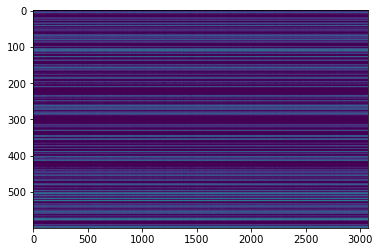

AUC      pAUC
Source_0  0.625800  0.550000
Source_1  0.748600  0.621579
Source_2  0.676500  0.502105
Target_0  0.550300  0.520526
Target_1  0.786600  0.561579
Target_2  0.634500  0.508421
mean      0.670383  0.544035
h_mean    0.661047  0.541160

2021-05-21 23:09:27,668 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1794.520955, val_AUC_hmean:0.661047, val_pAUC_hmean:0.541160, best_flag:True
2021-05-21 23:09:27,669 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.19it/s]
2021-05-21 23:09:28,130 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.86it/s]
2021-05-21 23:09:28,318 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


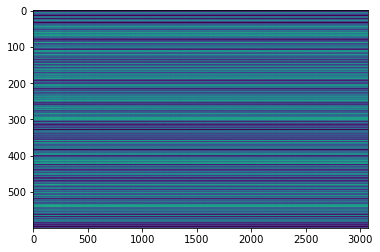

AUC      pAUC
Source_0  0.74620  0.534737
Source_1  0.71740  0.510000
Source_2  0.77160  0.547895
Target_0  0.68690  0.602632
Target_1  0.89710  0.611053
Target_2  0.77800  0.584737
mean      0.76620  0.565175
h_mean    0.76085  0.562740

2021-05-21 23:09:29,373 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1270.814128, val_AUC_hmean:0.760850, val_pAUC_hmean:0.562740, best_flag:True
2021-05-21 23:09:29,374 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.81it/s]
2021-05-21 23:09:29,842 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-21 23:09:30,051 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


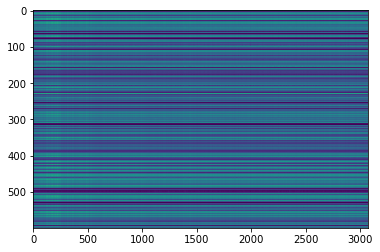

AUC      pAUC
Source_0  0.723600  0.532632
Source_1  0.733000  0.510526
Source_2  0.696300  0.598947
Target_0  0.738000  0.595789
Target_1  0.898900  0.656842
Target_2  0.900800  0.830526
mean      0.781767  0.620877
h_mean    0.773195  0.605402

2021-05-21 23:09:31,166 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1173.290558, val_AUC_hmean:0.773195, val_pAUC_hmean:0.605402, best_flag:True
2021-05-21 23:09:31,167 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.58it/s]
2021-05-21 23:09:31,658 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.59it/s]
2021-05-21 23:09:31,852 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-21 23:09:32,066 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1113.478383, val_AUC_hmean:0.644895, val_pAUC_hmean:0.552874, best_flag:False
2021-05-21 23:09:32,067 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.40it/s]
2021-05-21 23:09:32,542 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 23:09:32,752 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-21 23:09:

100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:09:45,714 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.93it/s]
2021-05-21 23:09:45,906 - pytorch_modeler.py - INFO - epoch:20/300, train_losses:740.662252, val_AUC_hmean:0.403605, val_pAUC_hmean:0.496106, best_flag:False
2021-05-21 23:09:45,907 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.82it/s]
2021-05-21 23:09:46,341 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-21 23:09:46,540 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:09:46,744 - pytorch_modeler.py - INFO - epoch:21/300, train_losses:725.059280, val_AUC_hmean:0.418507, val_pAUC_hmean:0.504239, best_flag:False
2021-05-21 23:09:46,745 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.74it/s]
2021-05-21 23:09:47,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 27.68it/s]
2021-05-21 23:10:00,034 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.47it/s]
2021-05-21 23:10:00,248 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-21 23:10:00,461 - pytorch_modeler.py - INFO - epoch:37/300, train_losses:521.410741, val_AUC_hmean:0.393934, val_pAUC_hmean:0.502711, best_flag:False
2021-05-21 23:10:00,463 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.12it/s]
2021-05-21 23:10:00,908 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-21 23:10:01,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-21 23:10:01,306 - pytorch_modeler.py - INFO - epoch:38/300, train_losses:511.274378, val_AUC_hmean:0.504141, val_pAUC_hmean:0.500945, best_flag:False
2021-05-21 23:10:01,307 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:10:14,102 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.45it/s]
2021-05-21 23:10:14,558 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 23:10:14,756 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.59it/s]
2021-05-21 23:10:14,956 - pytorch_modeler.py - INFO - epoch:54/300, train_losses:377.466390, val_AUC_hmean:0.368288, val_pAUC_hmean:0.508445, best_flag:False
2021-05-21 23:10:14,957 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.40it/s]
2021-05-21 23:10:15,397 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.85it/s]
2021-05-21 23:10:15,587 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.86it/s]
2021-05-21 23:10:15,780 - pytorch_modeler.py - INFO - epoch:55/300, train_losses:369.652959, val_AUC_hmean:0.387531, val_pAUC_hmean:0.511756, best_flag:False
2021-05-21 23:10

100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-21 23:10:28,503 - pytorch_modeler.py - INFO - epoch:70/300, train_losses:281.407679, val_AUC_hmean:0.467194, val_pAUC_hmean:0.505797, best_flag:False
2021-05-21 23:10:28,505 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.75it/s]
2021-05-21 23:10:28,956 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.33it/s]
2021-05-21 23:10:29,155 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-21 23:10:29,360 - pytorch_modeler.py - INFO - epoch:71/300, train_losses:274.585861, val_AUC_hmean:0.534634, val_pAUC_hmean:0.516705, best_flag:False
2021-05-21 23:10:29,360 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.55it/s]
2021-05-21 23:10:29,799 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:10:30,008 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.92it/s]
2021-05-21 23:10:42,751 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-21 23:10:42,965 - pytorch_modeler.py - INFO - epoch:87/300, train_losses:200.443209, val_AUC_hmean:0.488378, val_pAUC_hmean:0.511287, best_flag:False
2021-05-21 23:10:42,966 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.49it/s]
2021-05-21 23:10:43,405 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-21 23:10:43,603 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:10:43,807 - pytorch_modeler.py - INFO - epoch:88/300, train_losses:197.363595, val_AUC_hmean:0.474328, val_pAUC_hmean:0.512467, best_flag:False
2021-05-21 23:10:43,808 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.75it/s]
2021-05-21 23:10:44,259 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

2021-05-21 23:10:56,431 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.51it/s]
2021-05-21 23:10:56,870 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.91it/s]
2021-05-21 23:10:57,057 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:10:57,259 - pytorch_modeler.py - INFO - epoch:104/300, train_losses:144.636848, val_AUC_hmean:0.484179, val_pAUC_hmean:0.521997, best_flag:False
2021-05-21 23:10:57,260 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.35it/s]
2021-05-21 23:10:57,701 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.72it/s]
2021-05-21 23:10:57,892 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.84it/s]
2021-05-21 23:10:58,087 - pytorch_modeler.py - INFO - epoch:105/300, train_losses:142.771617, val_AUC_hmean:0.460050, val_pAUC_hmean:0.513382, best_flag:False
2021-05-21 23:

100%|██████████| 2/2 [00:00<00:00, 11.76it/s]
2021-05-21 23:11:10,734 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:106.983086, val_AUC_hmean:0.465426, val_pAUC_hmean:0.527494, best_flag:False
2021-05-21 23:11:10,735 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.03it/s]
2021-05-21 23:11:11,182 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]
2021-05-21 23:11:11,381 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.88it/s]
2021-05-21 23:11:11,573 - pytorch_modeler.py - INFO - epoch:121/300, train_losses:105.071578, val_AUC_hmean:0.580600, val_pAUC_hmean:0.511734, best_flag:False
2021-05-21 23:11:11,574 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.93it/s]
2021-05-21 23:11:12,021 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
2021-05-21 23:11:12,215 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-21 23:11:25,414 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:11:25,617 - pytorch_modeler.py - INFO - epoch:137/300, train_losses:78.329814, val_AUC_hmean:0.444115, val_pAUC_hmean:0.512112, best_flag:False
2021-05-21 23:11:25,618 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.63it/s]
2021-05-21 23:11:26,054 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:11:26,251 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:11:26,463 - pytorch_modeler.py - INFO - epoch:138/300, train_losses:76.057160, val_AUC_hmean:0.425262, val_pAUC_hmean:0.535353, best_flag:False
2021-05-21 23:11:26,464 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:11:26,943 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.84it/s]
2021-05-21 23:11:40,764 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:11:40,974 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-21 23:11:41,179 - pytorch_modeler.py - INFO - epoch:154/300, train_losses:54.760837, val_AUC_hmean:0.473464, val_pAUC_hmean:0.535975, best_flag:False
2021-05-21 23:11:41,180 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.75it/s]
2021-05-21 23:11:41,615 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.74it/s]
2021-05-21 23:11:41,806 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-21 23:11:42,035 - pytorch_modeler.py - INFO - epoch:155/300, train_losses:54.055854, val_AUC_hmean:0.565151, val_pAUC_hmean:0.528124, best_flag:False
2021-05-21 23:11:42,036 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:11:55,017 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.91it/s]
2021-05-21 23:11:55,521 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:11:55,734 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-21 23:11:55,944 - pytorch_modeler.py - INFO - epoch:171/300, train_losses:40.342048, val_AUC_hmean:0.536398, val_pAUC_hmean:0.521069, best_flag:False
2021-05-21 23:11:55,945 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.88it/s]
2021-05-21 23:11:56,430 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:11:56,628 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:11:56,838 - pytorch_modeler.py - INFO - epoch:172/300, train_losses:39.753012, val_AUC_hmean:0.486804, val_pAUC_hmean:0.522378, best_flag:False
2021-05-21 23:11

100%|██████████| 2/2 [00:00<00:00, 11.82it/s]
2021-05-21 23:12:10,515 - pytorch_modeler.py - INFO - epoch:187/300, train_losses:29.886606, val_AUC_hmean:0.428334, val_pAUC_hmean:0.509204, best_flag:False
2021-05-21 23:12:10,516 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.07it/s]
2021-05-21 23:12:10,979 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-21 23:12:11,173 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.70it/s]
2021-05-21 23:12:11,368 - pytorch_modeler.py - INFO - epoch:188/300, train_losses:28.836846, val_AUC_hmean:0.467896, val_pAUC_hmean:0.518758, best_flag:False
2021-05-21 23:12:11,370 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.18it/s]
2021-05-21 23:12:11,813 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.70it/s]
2021-05-21 23:12:12,005 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-21 23:12:24,885 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.67it/s]
2021-05-21 23:12:25,088 - pytorch_modeler.py - INFO - epoch:204/300, train_losses:19.763549, val_AUC_hmean:0.492762, val_pAUC_hmean:0.525284, best_flag:False
2021-05-21 23:12:25,089 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-05-21 23:12:25,539 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:12:25,743 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-21 23:12:25,952 - pytorch_modeler.py - INFO - epoch:205/300, train_losses:19.343277, val_AUC_hmean:0.603434, val_pAUC_hmean:0.522245, best_flag:False
2021-05-21 23:12:25,953 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.12it/s]
2021-05-21 23:12:26,398 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 27.86it/s]
2021-05-21 23:12:39,295 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:12:39,495 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
2021-05-21 23:12:39,691 - pytorch_modeler.py - INFO - epoch:221/300, train_losses:13.982173, val_AUC_hmean:0.492844, val_pAUC_hmean:0.529778, best_flag:False
2021-05-21 23:12:39,692 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.55it/s]
2021-05-21 23:12:40,130 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:12:40,326 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.74it/s]
2021-05-21 23:12:40,523 - pytorch_modeler.py - INFO - epoch:222/300, train_losses:13.810860, val_AUC_hmean:0.504120, val_pAUC_hmean:0.521777, best_flag:False
2021-05-21 23:12:40,524 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:12:53,470 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.93it/s]
2021-05-21 23:12:53,954 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]
2021-05-21 23:12:54,176 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-21 23:12:54,381 - pytorch_modeler.py - INFO - epoch:238/300, train_losses:9.999897, val_AUC_hmean:0.593133, val_pAUC_hmean:0.514895, best_flag:False
2021-05-21 23:12:54,382 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.14it/s]
2021-05-21 23:12:54,882 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.15it/s]
2021-05-21 23:12:55,108 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-21 23:12:55,325 - pytorch_modeler.py - INFO - epoch:239/300, train_losses:9.700523, val_AUC_hmean:0.557888, val_pAUC_hmean:0.517528, best_flag:False
2021-05-21 23:12:5

2021-05-21 23:13:08,901 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.19it/s]
2021-05-21 23:13:09,401 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.72it/s]
2021-05-21 23:13:09,592 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.63it/s]
2021-05-21 23:13:09,786 - pytorch_modeler.py - INFO - epoch:255/300, train_losses:6.939885, val_AUC_hmean:0.534372, val_pAUC_hmean:0.512153, best_flag:False
2021-05-21 23:13:09,788 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.00it/s]
2021-05-21 23:13:10,235 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:13:10,431 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.55it/s]
2021-05-21 23:13:10,630 - pytorch_modeler.py - INFO - epoch:256/300, train_losses:7.522243, val_AUC_hmean:0.510969, val_pAUC_hmean:0.516313, best_flag:False
2021-05-21 23:13:1

2021-05-21 23:13:23,342 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.13it/s]
2021-05-21 23:13:23,786 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.78it/s]
2021-05-21 23:13:23,976 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.67it/s]
2021-05-21 23:13:24,175 - pytorch_modeler.py - INFO - epoch:272/300, train_losses:4.792532, val_AUC_hmean:0.473154, val_pAUC_hmean:0.514989, best_flag:False
2021-05-21 23:13:24,177 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-05-21 23:13:24,635 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.79it/s]
2021-05-21 23:13:24,841 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:13:25,041 - pytorch_modeler.py - INFO - epoch:273/300, train_losses:4.968311, val_AUC_hmean:0.449062, val_pAUC_hmean:0.518418, best_flag:False
2021-05-21 23:13:2

2021-05-21 23:13:37,957 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.22it/s]
2021-05-21 23:13:38,417 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:13:38,614 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:13:38,827 - pytorch_modeler.py - INFO - epoch:289/300, train_losses:4.092610, val_AUC_hmean:0.582237, val_pAUC_hmean:0.538120, best_flag:False
2021-05-21 23:13:38,829 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.62it/s]
2021-05-21 23:13:39,300 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:13:39,499 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.20it/s]
2021-05-21 23:13:39,702 - pytorch_modeler.py - INFO - epoch:290/300, train_losses:3.673441, val_AUC_hmean:0.522041, val_pAUC_hmean:0.529282, best_flag:False
2021-05-21 23:13:3

AUC      pAUC
Source_0  0.723600  0.532632
Source_1  0.733000  0.510526
Source_2  0.696300  0.598947
Target_0  0.738000  0.595789
Target_1  0.898900  0.656842
Target_2  0.900800  0.830526
mean      0.781767  0.620877
h_mean    0.773195  0.605402

2021-05-21 23:13:48,189 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-05-21 23:13:48,189 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 23:13:48,221 - 00_train.py - INFO - TRAINING


elapsed time: 264.866914272 [sec]


2021-05-21 23:13:48,429 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 25.14it/s]
2021-05-21 23:13:48,908 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.68it/s]
2021-05-21 23:13:49,168 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


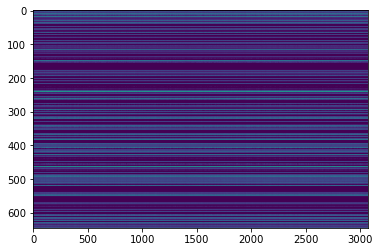

AUC      pAUC
Source_0  0.613236  0.582803
Source_1  0.754115  0.664826
Source_2  0.701959  0.578848
Target_0  0.823206  0.650037
Target_1  0.779835  0.606797
Target_2  0.709286  0.535923
mean      0.730273  0.603206
h_mean    0.723913  0.600007

2021-05-21 23:13:50,271 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2093.781779, val_AUC_hmean:0.723913, val_pAUC_hmean:0.600007, best_flag:True
2021-05-21 23:13:50,272 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-21 23:13:50,739 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.77it/s]
2021-05-21 23:13:50,947 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:13:51,150 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1582.134918, val_AUC_hmean:0.612022, val_pAUC_hmean:0.586930, best_flag:False
2021-05-21 23:13:51,152 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.12it/s]
2021-05-21 23:13:51,596 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 23:13:51,793 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.81it/s]
2021-05-21 23:13:

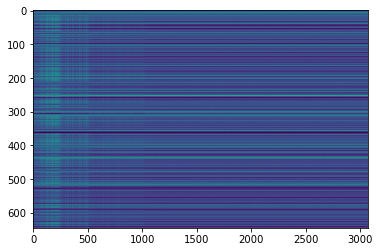

AUC      pAUC
Source_0  0.572601  0.518797
Source_1  0.851423  0.644159
Source_2  0.747719  0.650394
Target_0  0.736883  0.629630
Target_1  0.829561  0.651469
Target_2  0.732619  0.571011
mean      0.745134  0.610910
h_mean    0.732975  0.606552

2021-05-21 23:13:55,350 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1159.198822, val_AUC_hmean:0.732975, val_pAUC_hmean:0.606552, best_flag:True
2021-05-21 23:13:55,351 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.68it/s]
2021-05-21 23:13:55,803 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-21 23:13:56,015 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


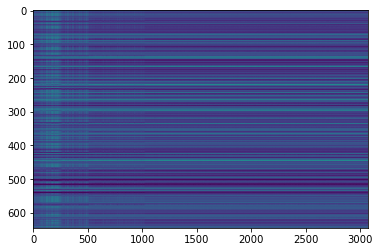

AUC      pAUC
Source_0  0.692503  0.561339
Source_1  0.859396  0.699300
Source_2  0.663446  0.585629
Target_0  0.808160  0.706689
Target_1  0.863940  0.769331
Target_2  0.684048  0.567251
mean      0.761916  0.648256
h_mean    0.752665  0.638516

2021-05-21 23:13:57,045 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1110.464620, val_AUC_hmean:0.752665, val_pAUC_hmean:0.638516, best_flag:True
2021-05-21 23:13:57,045 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.71it/s]
2021-05-21 23:13:57,497 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:13:57,712 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:13:57,913 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:1064.512736, val_AUC_hmean:0.663896, val_pAUC_hmean:0.556286, best_flag:False
2021-05-21 23:13:57,914 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.41it/s]
2021-05-21 23:13:58,354 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-21 23:13:58,553 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.61it/s]
2021-05-21 23:13:

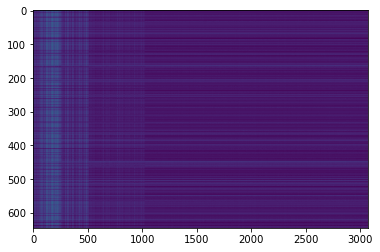

AUC      pAUC
Source_0  0.578168  0.568280
Source_1  0.817387  0.748033
Source_2  0.761608  0.648346
Target_0  0.855613  0.760396
Target_1  0.824246  0.748484
Target_2  0.733651  0.599415
mean      0.761779  0.678826
h_mean    0.748965  0.669766

2021-05-21 23:14:03,787 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:886.067688, val_AUC_hmean:0.748965, val_pAUC_hmean:0.669766, best_flag:True
2021-05-21 23:14:03,788 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.56it/s]
2021-05-21 23:14:04,226 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:14:04,430 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
2021-05-21 23:14:04,632 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:857.855387, val_AUC_hmean:0.725035, val_pAUC_hmean:0.633473, best_flag:False
2021-05-21 23:14:04,633 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.31it/s]
2021-05-21 23:14:05,075 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-21 23:14:05,281 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.33it/s]
2021-05-21 23:14:

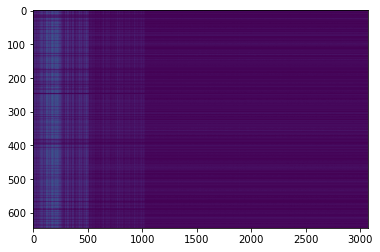

AUC      pAUC
Source_0  0.628181  0.610179
Source_1  0.824074  0.683507
Source_2  0.782676  0.629135
Target_0  0.873360  0.803038
Target_1  0.855453  0.755343
Target_2  0.768016  0.617586
mean      0.788627  0.683131
h_mean    0.779314  0.675693

2021-05-21 23:14:08,042 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:804.648473, val_AUC_hmean:0.779314, val_pAUC_hmean:0.675693, best_flag:True
2021-05-21 23:14:08,043 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.97it/s]
2021-05-21 23:14:08,526 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.05it/s]
2021-05-21 23:14:08,769 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


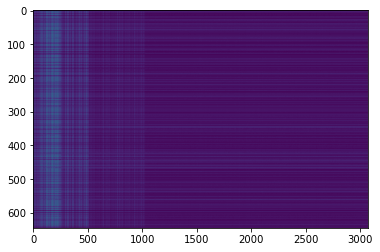

AUC      pAUC
Source_0  0.684786  0.600411
Source_1  0.813272  0.677280
Source_2  0.756643  0.650747
Target_0  0.851370  0.740599
Target_1  0.884774  0.793065
Target_2  0.785476  0.644319
mean      0.796053  0.684404
h_mean    0.790570  0.678585

2021-05-21 23:14:09,807 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:774.214325, val_AUC_hmean:0.790570, val_pAUC_hmean:0.678585, best_flag:True
2021-05-21 23:14:09,809 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.02it/s]
2021-05-21 23:14:10,291 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
2021-05-21 23:14:10,512 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-21 23:14:10,723 - pytorch_modeler.py - INFO - epoch:20/300, train_losses:752.449961, val_AUC_hmean:0.732548, val_pAUC_hmean:0.639811, best_flag:False
2021-05-21 23:14:10,725 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.68it/s]
2021-05-21 23:14:11,177 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-21 23:14:11,399 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:14:

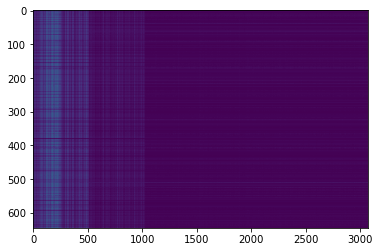

AUC      pAUC
Source_0  0.622711  0.555941
Source_1  0.823988  0.790900
Source_2  0.793277  0.666356
Target_0  0.866512  0.709227
Target_1  0.842507  0.782597
Target_2  0.754286  0.631788
mean      0.783880  0.689468
h_mean    0.774510  0.679161

2021-05-21 23:14:15,120 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:703.249522, val_AUC_hmean:0.774510, val_pAUC_hmean:0.679161, best_flag:True
2021-05-21 23:14:15,122 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.85it/s]
2021-05-21 23:14:15,729 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.29it/s]
2021-05-21 23:14:16,070 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
2021-05-21 23:14:16,400 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:683.607656, val_AUC_hmean:0.755931, val_pAUC_hmean:0.661238, best_flag:False
2021-05-21 23:14:16,401 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.45it/s]
2021-05-21 23:14:16,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
2021-05-21 23:14:17,313 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]
2021-05-21 23:14:

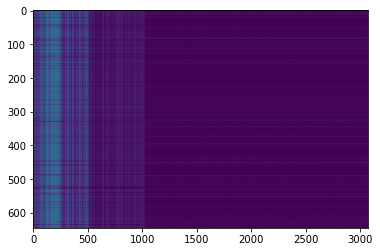

AUC      pAUC
Source_0  0.682295  0.583189
Source_1  0.876972  0.762743
Source_2  0.762681  0.687615
Target_0  0.900077  0.786996
Target_1  0.894119  0.800827
Target_2  0.727937  0.611111
mean      0.807347  0.705413
h_mean    0.797843  0.694782

2021-05-21 23:14:22,549 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:605.312836, val_AUC_hmean:0.797843, val_pAUC_hmean:0.694782, best_flag:True
2021-05-21 23:14:22,550 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.33it/s]
2021-05-21 23:14:23,008 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:14:23,217 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.90it/s]
2021-05-21 23:14:23,409 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:599.830098, val_AUC_hmean:0.777096, val_pAUC_hmean:0.660448, best_flag:False
2021-05-21 23:14:23,410 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.02it/s]
2021-05-21 23:14:23,857 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-21 23:14:24,074 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-21 23:14:

100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-21 23:14:36,883 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.98it/s]
2021-05-21 23:14:37,077 - pytorch_modeler.py - INFO - epoch:47/300, train_losses:430.377772, val_AUC_hmean:0.747890, val_pAUC_hmean:0.649455, best_flag:False
2021-05-21 23:14:37,078 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.58it/s]
2021-05-21 23:14:37,516 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 23:14:37,713 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:14:37,920 - pytorch_modeler.py - INFO - epoch:48/300, train_losses:423.886541, val_AUC_hmean:0.737600, val_pAUC_hmean:0.641899, best_flag:False
2021-05-21 23:14:37,921 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.58it/s]
2021-05-21 23:14:38,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.28it/s]
2021-05-21 23:14:51,481 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.61it/s]
2021-05-21 23:14:51,674 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:14:51,874 - pytorch_modeler.py - INFO - epoch:64/300, train_losses:312.959986, val_AUC_hmean:0.749144, val_pAUC_hmean:0.640986, best_flag:False
2021-05-21 23:14:51,875 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.15it/s]
2021-05-21 23:14:52,320 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
2021-05-21 23:14:52,514 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-21 23:14:52,717 - pytorch_modeler.py - INFO - epoch:65/300, train_losses:306.931758, val_AUC_hmean:0.746358, val_pAUC_hmean:0.641668, best_flag:False
2021-05-21 23:14:52,718 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:15:05,706 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.14it/s]
2021-05-21 23:15:06,150 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 23:15:06,345 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-21 23:15:06,540 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:230.877085, val_AUC_hmean:0.794836, val_pAUC_hmean:0.692136, best_flag:False
2021-05-21 23:15:06,541 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.38it/s]
2021-05-21 23:15:06,982 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:15:07,184 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.76it/s]
2021-05-21 23:15:07,378 - pytorch_modeler.py - INFO - epoch:82/300, train_losses:224.805332, val_AUC_hmean:0.766154, val_pAUC_hmean:0.647536, best_flag:False
2021-05-21 23:15

100%|██████████| 2/2 [00:00<00:00, 11.72it/s]
2021-05-21 23:15:20,163 - pytorch_modeler.py - INFO - epoch:97/300, train_losses:167.726851, val_AUC_hmean:0.743966, val_pAUC_hmean:0.644946, best_flag:False
2021-05-21 23:15:20,165 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.17it/s]
2021-05-21 23:15:20,609 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
2021-05-21 23:15:20,803 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.85it/s]
2021-05-21 23:15:20,994 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:163.930664, val_AUC_hmean:0.739147, val_pAUC_hmean:0.646537, best_flag:False
2021-05-21 23:15:20,995 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.59it/s]
2021-05-21 23:15:21,433 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-21 23:15:21,635 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-05-21 23:15:34,190 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 23:15:34,386 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:15:34,587 - pytorch_modeler.py - INFO - epoch:114/300, train_losses:120.537967, val_AUC_hmean:0.728338, val_pAUC_hmean:0.632980, best_flag:False
2021-05-21 23:15:34,588 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.40it/s]
2021-05-21 23:15:35,028 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.52it/s]
2021-05-21 23:15:35,221 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
2021-05-21 23:15:35,420 - pytorch_modeler.py - INFO - epoch:115/300, train_losses:117.769761, val_AUC_hmean:0.737887, val_pAUC_hmean:0.645409, best_flag:False
2021-05-21 23:15:35,421 - pytorch_modeler.py - INFO - train
100%|█████████

2021-05-21 23:15:48,300 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.00it/s]
2021-05-21 23:15:48,764 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.52it/s]
2021-05-21 23:15:48,957 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:15:49,162 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:86.812330, val_AUC_hmean:0.739048, val_pAUC_hmean:0.627593, best_flag:False
2021-05-21 23:15:49,163 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.37it/s]
2021-05-21 23:15:49,640 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-21 23:15:49,857 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.68it/s]
2021-05-21 23:15:50,052 - pytorch_modeler.py - INFO - epoch:132/300, train_losses:84.676201, val_AUC_hmean:0.723710, val_pAUC_hmean:0.624517, best_flag:False
2021-05-21 23:15

100%|██████████| 2/2 [00:00<00:00, 12.04it/s]
2021-05-21 23:16:02,692 - pytorch_modeler.py - INFO - epoch:147/300, train_losses:67.247217, val_AUC_hmean:0.738590, val_pAUC_hmean:0.650399, best_flag:False
2021-05-21 23:16:02,693 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.68it/s]
2021-05-21 23:16:03,129 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-21 23:16:03,348 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:16:03,550 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:69.045859, val_AUC_hmean:0.793294, val_pAUC_hmean:0.683623, best_flag:False
2021-05-21 23:16:03,551 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.74it/s]
2021-05-21 23:16:03,986 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.58it/s]
2021-05-21 23:16:04,177 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 11.38it/s]
2021-05-21 23:16:16,581 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:16:16,786 - pytorch_modeler.py - INFO - epoch:164/300, train_losses:49.301194, val_AUC_hmean:0.741739, val_pAUC_hmean:0.654327, best_flag:False
2021-05-21 23:16:16,788 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.57it/s]
2021-05-21 23:16:17,243 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:16:17,439 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.08it/s]
2021-05-21 23:16:17,627 - pytorch_modeler.py - INFO - epoch:165/300, train_losses:47.420447, val_AUC_hmean:0.721915, val_pAUC_hmean:0.660766, best_flag:False
2021-05-21 23:16:17,628 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.64it/s]
2021-05-21 23:16:18,065 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 27.29it/s]
2021-05-21 23:16:30,929 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:16:31,139 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-21 23:16:31,349 - pytorch_modeler.py - INFO - epoch:181/300, train_losses:31.388882, val_AUC_hmean:0.742426, val_pAUC_hmean:0.642022, best_flag:False
2021-05-21 23:16:31,351 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.04it/s]
2021-05-21 23:16:31,875 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-21 23:16:32,086 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.51it/s]
2021-05-21 23:16:32,302 - pytorch_modeler.py - INFO - epoch:182/300, train_losses:30.168373, val_AUC_hmean:0.743223, val_pAUC_hmean:0.634193, best_flag:False
2021-05-21 23:16:32,303 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:16:45,068 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.61it/s]
2021-05-21 23:16:45,539 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-21 23:16:45,745 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:16:45,948 - pytorch_modeler.py - INFO - epoch:198/300, train_losses:21.776461, val_AUC_hmean:0.735673, val_pAUC_hmean:0.642045, best_flag:False
2021-05-21 23:16:45,948 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.11it/s]
2021-05-21 23:16:46,394 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.71it/s]
2021-05-21 23:16:46,583 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.78it/s]
2021-05-21 23:16:46,775 - pytorch_modeler.py - INFO - epoch:199/300, train_losses:21.117668, val_AUC_hmean:0.706136, val_pAUC_hmean:0.629525, best_flag:False
2021-05-21 23:16

100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:16:59,348 - pytorch_modeler.py - INFO - epoch:214/300, train_losses:15.339027, val_AUC_hmean:0.709640, val_pAUC_hmean:0.622460, best_flag:False
2021-05-21 23:16:59,349 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.82it/s]
2021-05-21 23:16:59,816 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.58it/s]
2021-05-21 23:17:00,008 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.02it/s]
2021-05-21 23:17:00,197 - pytorch_modeler.py - INFO - epoch:215/300, train_losses:15.290787, val_AUC_hmean:0.722401, val_pAUC_hmean:0.621980, best_flag:False
2021-05-21 23:17:00,198 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.95it/s]
2021-05-21 23:17:00,662 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
2021-05-21 23:17:00,860 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:17:13,971 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:17:14,176 - pytorch_modeler.py - INFO - epoch:231/300, train_losses:10.899145, val_AUC_hmean:0.730615, val_pAUC_hmean:0.623125, best_flag:False
2021-05-21 23:17:14,177 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.69it/s]
2021-05-21 23:17:14,646 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:17:14,845 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.60it/s]
2021-05-21 23:17:15,042 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:10.465029, val_AUC_hmean:0.714411, val_pAUC_hmean:0.603810, best_flag:False
2021-05-21 23:17:15,043 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.08it/s]
2021-05-21 23:17:15,489 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.56it/s]
2021-05-21 23:17:28,407 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:17:28,609 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.02it/s]
2021-05-21 23:17:28,798 - pytorch_modeler.py - INFO - epoch:248/300, train_losses:7.157927, val_AUC_hmean:0.716779, val_pAUC_hmean:0.617122, best_flag:False
2021-05-21 23:17:28,799 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.94it/s]
2021-05-21 23:17:29,303 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.92it/s]
2021-05-21 23:17:29,505 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
2021-05-21 23:17:29,696 - pytorch_modeler.py - INFO - epoch:249/300, train_losses:6.773949, val_AUC_hmean:0.725748, val_pAUC_hmean:0.629127, best_flag:False
2021-05-21 23:17:29,697 - pytorch_modeler.py - INFO - train
100%|██████████| 1

2021-05-21 23:17:42,655 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.68it/s]
2021-05-21 23:17:43,125 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.33it/s]
2021-05-21 23:17:43,321 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:17:43,530 - pytorch_modeler.py - INFO - epoch:265/300, train_losses:6.155180, val_AUC_hmean:0.702345, val_pAUC_hmean:0.604162, best_flag:False
2021-05-21 23:17:43,531 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.42it/s]
2021-05-21 23:17:43,971 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
2021-05-21 23:17:44,164 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:17:44,368 - pytorch_modeler.py - INFO - epoch:266/300, train_losses:5.709031, val_AUC_hmean:0.731761, val_pAUC_hmean:0.627253, best_flag:False
2021-05-21 23:17:4

2021-05-21 23:17:57,311 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.58it/s]
2021-05-21 23:17:57,782 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.74it/s]
2021-05-21 23:17:57,971 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.07it/s]
2021-05-21 23:17:58,158 - pytorch_modeler.py - INFO - epoch:282/300, train_losses:9.221686, val_AUC_hmean:0.729589, val_pAUC_hmean:0.619149, best_flag:False
2021-05-21 23:17:58,159 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.38it/s]
2021-05-21 23:17:58,600 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-21 23:17:58,816 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 12.12it/s]
2021-05-21 23:17:59,002 - pytorch_modeler.py - INFO - epoch:283/300, train_losses:15.469422, val_AUC_hmean:0.728167, val_pAUC_hmean:0.621217, best_flag:False
2021-05-21 23:17:

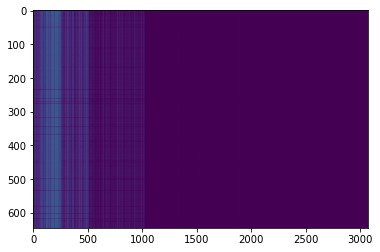

AUC      pAUC
Source_0  0.686593  0.594628
Source_1  0.933985  0.835391
Source_2  0.757515  0.653996
Target_0  0.908083  0.780194
Target_1  0.917181  0.807144
Target_2  0.743651  0.630326
mean      0.824501  0.716946
h_mean    0.812624  0.704641

2021-05-21 23:18:04,084 - pytorch_modeler.py - INFO - epoch:288/300, train_losses:14.426307, val_AUC_hmean:0.812624, val_pAUC_hmean:0.704641, best_flag:True
2021-05-21 23:18:04,085 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.87it/s]
2021-05-21 23:18:04,534 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:18:04,733 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.66it/s]
2021-05-21 23:18:04,927 - pytorch_modeler.py - INFO - epoch:289/300, train_losses:19.190456, val_AUC_hmean:0.603686, val_pAUC_hmean:0.567707, best_flag:False
2021-05-21 23:18:04,928 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.32it/s]
2021-05-21 23:18:05,370 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-21 23:18:05,575 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.54it/s]
2021-05-21 23:18:

AUC      pAUC
Source_0  0.686593  0.594628
Source_1  0.933985  0.835391
Source_2  0.757515  0.653996
Target_0  0.908083  0.780194
Target_1  0.917181  0.807144
Target_2  0.743651  0.630326
mean      0.824501  0.716946
h_mean    0.812624  0.704641

2021-05-21 23:18:14,596 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-05-21 23:18:14,597 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 23:18:14,629 - 00_train.py - INFO - TRAINING


elapsed time: 266.406985283 [sec]


2021-05-21 23:18:14,828 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 24.13it/s]
2021-05-21 23:18:15,327 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 23:18:15,521 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


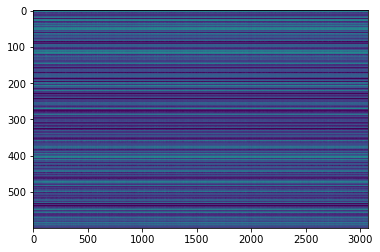

AUC      pAUC
Source_0  0.428400  0.534211
Source_1  0.509100  0.506842
Source_2  0.434300  0.516842
Target_0  0.448600  0.493158
Target_1  0.544700  0.572105
Target_2  0.341800  0.485263
mean      0.451150  0.518070
h_mean    0.441443  0.516522

2021-05-21 23:18:16,562 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2105.656952, val_AUC_hmean:0.441443, val_pAUC_hmean:0.516522, best_flag:True
2021-05-21 23:18:16,563 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.91it/s]
2021-05-21 23:18:17,028 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:18:17,233 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-21 23:18:17,457 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1420.614858, val_AUC_hmean:0.439922, val_pAUC_hmean:0.511284, best_flag:False
2021-05-21 23:18:17,458 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-05-21 23:18:17,922 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-21 23:18:18,132 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.66it/s]
2021-05-21 23:18:

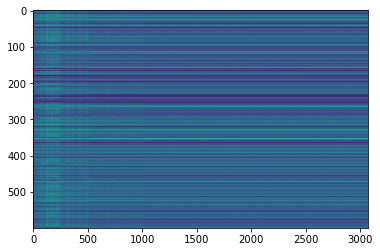

AUC      pAUC
Source_0  0.527200  0.489474
Source_1  0.507500  0.491053
Source_2  0.708200  0.542105
Target_0  0.593500  0.506842
Target_1  0.673500  0.600000
Target_2  0.525800  0.511579
mean      0.589283  0.523509
h_mean    0.579662  0.520901

2021-05-21 23:18:21,844 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1105.954030, val_AUC_hmean:0.579662, val_pAUC_hmean:0.520901, best_flag:True
2021-05-21 23:18:21,845 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.56it/s]
2021-05-21 23:18:22,317 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.07it/s]
2021-05-21 23:18:22,538 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


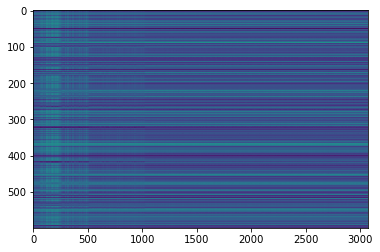

AUC      pAUC
Source_0  0.620200  0.504737
Source_1  0.516400  0.486842
Source_2  0.741800  0.584737
Target_0  0.584600  0.525789
Target_1  0.677600  0.611579
Target_2  0.455400  0.501579
mean      0.599333  0.535877
h_mean    0.583704  0.532095

2021-05-21 23:18:23,636 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1072.100616, val_AUC_hmean:0.583704, val_pAUC_hmean:0.532095, best_flag:True
2021-05-21 23:18:23,637 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.21it/s]
2021-05-21 23:18:24,115 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-21 23:18:24,330 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


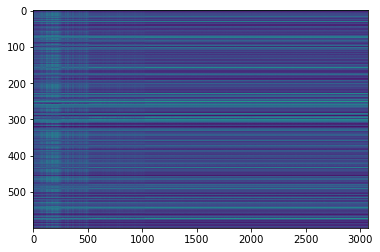

AUC      pAUC
Source_0  0.630300  0.538947
Source_1  0.534900  0.492105
Source_2  0.702900  0.616842
Target_0  0.660300  0.528947
Target_1  0.678700  0.609474
Target_2  0.382500  0.495789
mean      0.598267  0.547018
h_mean    0.572466  0.542642

2021-05-21 23:18:25,437 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:1042.024134, val_AUC_hmean:0.572466, val_pAUC_hmean:0.542642, best_flag:True
2021-05-21 23:18:25,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.94it/s]
2021-05-21 23:18:25,902 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-21 23:18:26,107 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


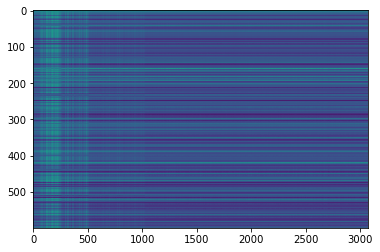

AUC      pAUC
Source_0  0.637200  0.546316
Source_1  0.549300  0.487895
Source_2  0.772000  0.643158
Target_0  0.610000  0.561053
Target_1  0.670000  0.634737
Target_2  0.474700  0.510000
mean      0.618867  0.563860
h_mean    0.604615  0.557958

2021-05-21 23:18:27,176 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:1008.683482, val_AUC_hmean:0.604615, val_pAUC_hmean:0.557958, best_flag:True
2021-05-21 23:18:27,177 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.19it/s]
2021-05-21 23:18:27,676 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:18:27,890 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


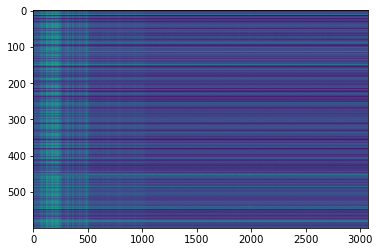

AUC      pAUC
Source_0  0.675800  0.547368
Source_1  0.557900  0.486316
Source_2  0.790500  0.650526
Target_0  0.651800  0.598947
Target_1  0.678700  0.623158
Target_2  0.459800  0.498421
mean      0.635750  0.567456
h_mean    0.617305  0.560691

2021-05-21 23:18:29,004 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:981.418955, val_AUC_hmean:0.617305, val_pAUC_hmean:0.560691, best_flag:True
2021-05-21 23:18:29,005 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-21 23:18:29,472 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.86it/s]
2021-05-21 23:18:29,697 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


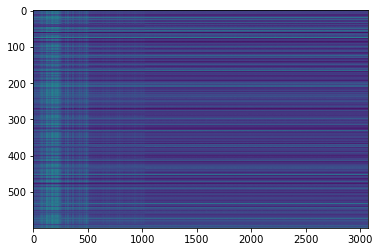

AUC      pAUC
Source_0  0.656100  0.565263
Source_1  0.557300  0.497895
Source_2  0.789400  0.654211
Target_0  0.705200  0.580526
Target_1  0.680300  0.640526
Target_2  0.479700  0.496842
mean      0.644667  0.572544
h_mean    0.627752  0.565899

2021-05-21 23:18:30,791 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:960.088252, val_AUC_hmean:0.627752, val_pAUC_hmean:0.565899, best_flag:True
2021-05-21 23:18:30,793 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.46it/s]
2021-05-21 23:18:31,232 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
2021-05-21 23:18:31,459 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 23:18:31,671 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:938.336151, val_AUC_hmean:0.594574, val_pAUC_hmean:0.555508, best_flag:False
2021-05-21 23:18:31,672 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.96it/s]
2021-05-21 23:18:32,176 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-21 23:18:32,408 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:18:

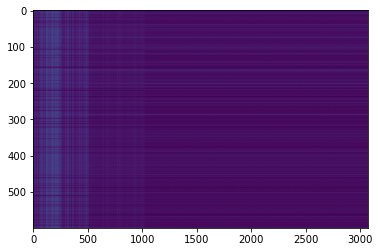

AUC      pAUC
Source_0  0.661300  0.586842
Source_1  0.597400  0.512632
Source_2  0.801200  0.667895
Target_0  0.692300  0.590000
Target_1  0.672600  0.620526
Target_2  0.498700  0.496842
mean      0.653917  0.579123
h_mean    0.640296  0.573002

2021-05-21 23:18:37,908 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:831.649790, val_AUC_hmean:0.640296, val_pAUC_hmean:0.573002, best_flag:True
2021-05-21 23:18:37,909 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.01it/s]
2021-05-21 23:18:38,356 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
2021-05-21 23:18:38,551 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.57it/s]
2021-05-21 23:18:38,786 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:817.208796, val_AUC_hmean:0.625271, val_pAUC_hmean:0.550400, best_flag:False
2021-05-21 23:18:38,787 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.20it/s]
2021-05-21 23:18:39,247 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-21 23:18:39,464 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-21 23:18:

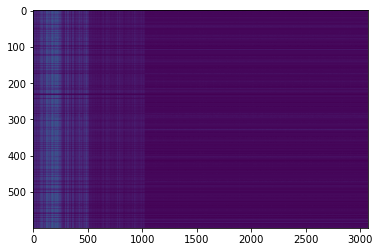

AUC      pAUC
Source_0  0.728000  0.607368
Source_1  0.647600  0.526842
Source_2  0.753000  0.682632
Target_0  0.691800  0.614211
Target_1  0.663800  0.603684
Target_2  0.432600  0.497895
mean      0.652800  0.588772
h_mean    0.630955  0.582381

2021-05-21 23:18:44,048 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:737.853739, val_AUC_hmean:0.630955, val_pAUC_hmean:0.582381, best_flag:True
2021-05-21 23:18:44,048 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.82it/s]
2021-05-21 23:18:44,515 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-21 23:18:44,736 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.17it/s]
2021-05-21 23:18:44,959 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:723.883682, val_AUC_hmean:0.628244, val_pAUC_hmean:0.573848, best_flag:False
2021-05-21 23:18:44,960 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.29it/s]
2021-05-21 23:18:45,456 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-21 23:18:45,672 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


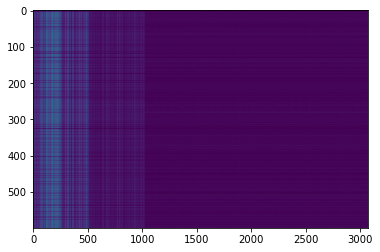

AUC      pAUC
Source_0  0.711200  0.622632
Source_1  0.629200  0.524211
Source_2  0.826700  0.681053
Target_0  0.709000  0.624211
Target_1  0.675600  0.602632
Target_2  0.459000  0.494211
mean      0.668450  0.591491
h_mean    0.646951  0.584404

2021-05-21 23:18:46,700 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:708.971161, val_AUC_hmean:0.646951, val_pAUC_hmean:0.584404, best_flag:True
2021-05-21 23:18:46,701 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-05-21 23:18:47,159 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.34it/s]
2021-05-21 23:18:47,356 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


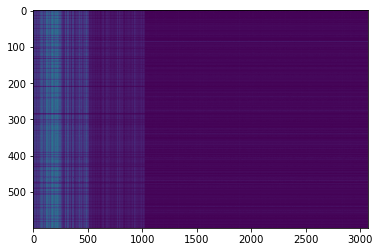

AUC      pAUC
Source_0  0.738400  0.641579
Source_1  0.627400  0.520000
Source_2  0.826100  0.705789
Target_0  0.717100  0.630526
Target_1  0.663600  0.596842
Target_2  0.453000  0.495789
mean      0.670933  0.598421
h_mean    0.647416  0.589563

2021-05-21 23:18:48,390 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:695.899211, val_AUC_hmean:0.647416, val_pAUC_hmean:0.589563, best_flag:True
2021-05-21 23:18:48,391 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.34it/s]
2021-05-21 23:18:48,868 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.24it/s]
2021-05-21 23:18:49,085 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:18:49,303 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:683.856059, val_AUC_hmean:0.621551, val_pAUC_hmean:0.584212, best_flag:False
2021-05-21 23:18:49,305 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.90it/s]
2021-05-21 23:18:49,789 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-21 23:18:50,011 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


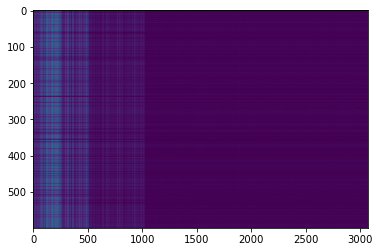

AUC      pAUC
Source_0  0.706600  0.636316
Source_1  0.617000  0.534737
Source_2  0.724700  0.690000
Target_0  0.730800  0.620526
Target_1  0.657100  0.607368
Target_2  0.399900  0.495263
mean      0.639350  0.597368
h_mean    0.611828  0.590086

2021-05-21 23:18:51,053 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:671.004862, val_AUC_hmean:0.611828, val_pAUC_hmean:0.590086, best_flag:True
2021-05-21 23:18:51,054 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-05-21 23:18:51,518 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:18:51,723 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:18:51,928 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:661.592916, val_AUC_hmean:0.594658, val_pAUC_hmean:0.555483, best_flag:False
2021-05-21 23:18:51,930 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.98it/s]
2021-05-21 23:18:52,394 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:18:52,604 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-21 23:18:

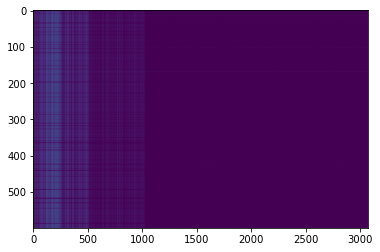

AUC      pAUC
Source_0  0.730700  0.616842
Source_1  0.621800  0.561053
Source_2  0.749800  0.705789
Target_0  0.707000  0.619474
Target_1  0.658900  0.595789
Target_2  0.467600  0.490526
mean      0.655967  0.598246
h_mean    0.639580  0.591033

2021-05-21 23:19:05,449 - pytorch_modeler.py - INFO - epoch:44/300, train_losses:512.011269, val_AUC_hmean:0.639580, val_pAUC_hmean:0.591033, best_flag:True
2021-05-21 23:19:05,450 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.53it/s]
2021-05-21 23:19:05,942 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.46it/s]
2021-05-21 23:19:06,199 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
2021-05-21 23:19:06,429 - pytorch_modeler.py - INFO - epoch:45/300, train_losses:502.565567, val_AUC_hmean:0.596293, val_pAUC_hmean:0.589060, best_flag:False
2021-05-21 23:19:06,431 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.14it/s]
2021-05-21 23:19:06,892 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
2021-05-21 23:19:07,114 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
2021-05-21 23:19:

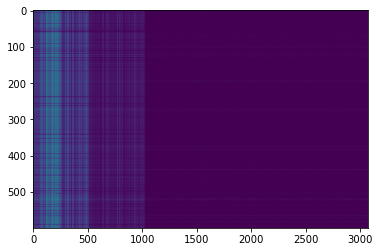

AUC      pAUC
Source_0  0.680500  0.624737
Source_1  0.623300  0.566842
Source_2  0.781100  0.697895
Target_0  0.618900  0.614737
Target_1  0.639900  0.591053
Target_2  0.394800  0.491579
mean      0.623083  0.597807
h_mean    0.596092  0.591099

2021-05-21 23:19:11,960 - pytorch_modeler.py - INFO - epoch:50/300, train_losses:459.271060, val_AUC_hmean:0.596092, val_pAUC_hmean:0.591099, best_flag:True
2021-05-21 23:19:11,961 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.04it/s]
2021-05-21 23:19:12,406 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:19:12,619 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.41it/s]
2021-05-21 23:19:12,837 - pytorch_modeler.py - INFO - epoch:51/300, train_losses:450.919551, val_AUC_hmean:0.607932, val_pAUC_hmean:0.587839, best_flag:False
2021-05-21 23:19:12,838 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.30it/s]
2021-05-21 23:19:13,297 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:19:13,501 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


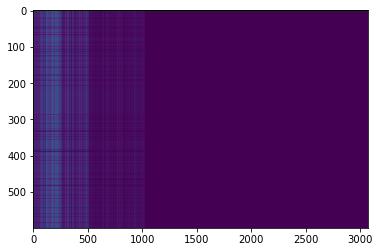

AUC      pAUC
Source_0  0.723400  0.623684
Source_1  0.645000  0.560526
Source_2  0.783500  0.701579
Target_0  0.687300  0.630000
Target_1  0.664300  0.592105
Target_2  0.384300  0.487895
mean      0.647967  0.599298
h_mean    0.614029  0.591799

2021-05-21 23:19:14,590 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:442.727435, val_AUC_hmean:0.614029, val_pAUC_hmean:0.591799, best_flag:True
2021-05-21 23:19:14,591 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.68it/s]
2021-05-21 23:19:15,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-21 23:19:15,292 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.85it/s]
2021-05-21 23:19:15,523 - pytorch_modeler.py - INFO - epoch:53/300, train_losses:435.945788, val_AUC_hmean:0.631750, val_pAUC_hmean:0.583676, best_flag:False
2021-05-21 23:19:15,524 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.15it/s]
2021-05-21 23:19:15,985 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-21 23:19:16,207 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
2021-05-21 23:19:

100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:19:29,942 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.68it/s]
2021-05-21 23:19:30,198 - pytorch_modeler.py - INFO - epoch:69/300, train_losses:330.543546, val_AUC_hmean:0.608136, val_pAUC_hmean:0.572495, best_flag:False
2021-05-21 23:19:30,199 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.72it/s]
2021-05-21 23:19:30,668 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-21 23:19:30,881 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-21 23:19:31,091 - pytorch_modeler.py - INFO - epoch:70/300, train_losses:323.449674, val_AUC_hmean:0.616621, val_pAUC_hmean:0.571419, best_flag:False
2021-05-21 23:19:31,092 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.21it/s]
2021-05-21 23:19:31,590 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

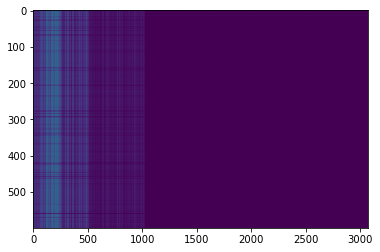

AUC      pAUC
Source_0  0.700500  0.614737
Source_1  0.629700  0.572632
Source_2  0.726400  0.704211
Target_0  0.603100  0.624737
Target_1  0.647400  0.618947
Target_2  0.609900  0.488421
mean      0.652833  0.603947
h_mean    0.649729  0.596611

2021-05-21 23:19:41,077 - pytorch_modeler.py - INFO - epoch:80/300, train_losses:269.939697, val_AUC_hmean:0.649729, val_pAUC_hmean:0.596611, best_flag:True
2021-05-21 23:19:41,078 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.46it/s]
2021-05-21 23:19:41,533 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-21 23:19:41,741 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


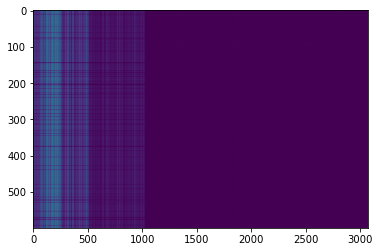

AUC      pAUC
Source_0  0.652500  0.607895
Source_1  0.640400  0.587895
Source_2  0.797600  0.707368
Target_0  0.625300  0.620000
Target_1  0.649600  0.620000
Target_2  0.440900  0.486316
mean      0.634383  0.604912
h_mean    0.615096  0.597504

2021-05-21 23:19:42,798 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:264.753298, val_AUC_hmean:0.615096, val_pAUC_hmean:0.597504, best_flag:True
2021-05-21 23:19:42,799 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.73it/s]
2021-05-21 23:19:43,286 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:19:43,492 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
2021-05-21 23:19:43,704 - pytorch_modeler.py - INFO - epoch:82/300, train_losses:260.327128, val_AUC_hmean:0.643775, val_pAUC_hmean:0.591395, best_flag:False
2021-05-21 23:19:43,705 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-05-21 23:19:44,154 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-21 23:19:44,356 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:19:

100%|██████████| 2/2 [00:00<00:00, 10.17it/s]
2021-05-21 23:19:57,780 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:19:57,984 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:196.457382, val_AUC_hmean:0.629905, val_pAUC_hmean:0.592469, best_flag:False
2021-05-21 23:19:57,985 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.18it/s]
2021-05-21 23:19:58,428 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:19:58,632 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:19:58,840 - pytorch_modeler.py - INFO - epoch:99/300, train_losses:192.820363, val_AUC_hmean:0.633321, val_pAUC_hmean:0.594160, best_flag:False
2021-05-21 23:19:58,841 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.15it/s]
2021-05-21 23:19:59,302 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

2021-05-21 23:20:12,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.91it/s]
2021-05-21 23:20:12,512 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-21 23:20:12,713 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.33it/s]
2021-05-21 23:20:12,913 - pytorch_modeler.py - INFO - epoch:115/300, train_losses:145.703138, val_AUC_hmean:0.630442, val_pAUC_hmean:0.586782, best_flag:False
2021-05-21 23:20:12,914 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.39it/s]
2021-05-21 23:20:13,371 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:20:13,575 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-21 23:20:13,774 - pytorch_modeler.py - INFO - epoch:116/300, train_losses:143.431905, val_AUC_hmean:0.558907, val_pAUC_hmean:0.587699, best_flag:False
2021-05-21 23:

100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:20:27,013 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:109.585128, val_AUC_hmean:0.580949, val_pAUC_hmean:0.592272, best_flag:False
2021-05-21 23:20:27,014 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.18it/s]
2021-05-21 23:20:27,475 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-21 23:20:27,684 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:20:27,884 - pytorch_modeler.py - INFO - epoch:132/300, train_losses:115.971324, val_AUC_hmean:0.496299, val_pAUC_hmean:0.539949, best_flag:False
2021-05-21 23:20:27,885 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.96it/s]
2021-05-21 23:20:28,368 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:20:28,582 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:20:41,704 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:20:41,908 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:81.592232, val_AUC_hmean:0.608720, val_pAUC_hmean:0.585485, best_flag:False
2021-05-21 23:20:41,910 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.93it/s]
2021-05-21 23:20:42,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-21 23:20:42,579 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:20:42,783 - pytorch_modeler.py - INFO - epoch:149/300, train_losses:80.624827, val_AUC_hmean:0.612329, val_pAUC_hmean:0.582196, best_flag:False
2021-05-21 23:20:42,784 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.11it/s]
2021-05-21 23:20:43,246 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.72it/s]
2021-05-21 23:20:56,675 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:20:56,876 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.97it/s]
2021-05-21 23:20:57,083 - pytorch_modeler.py - INFO - epoch:165/300, train_losses:60.349210, val_AUC_hmean:0.652321, val_pAUC_hmean:0.592013, best_flag:False
2021-05-21 23:20:57,084 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.49it/s]
2021-05-21 23:20:57,540 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.65it/s]
2021-05-21 23:20:57,751 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-21 23:20:57,960 - pytorch_modeler.py - INFO - epoch:166/300, train_losses:58.899810, val_AUC_hmean:0.551024, val_pAUC_hmean:0.586610, best_flag:False
2021-05-21 23:20:57,961 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:21:11,065 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-05-21 23:21:11,525 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:21:11,729 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:21:11,936 - pytorch_modeler.py - INFO - epoch:182/300, train_losses:44.021194, val_AUC_hmean:0.645064, val_pAUC_hmean:0.583665, best_flag:False
2021-05-21 23:21:11,937 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.41it/s]
2021-05-21 23:21:12,377 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:21:12,581 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:21:12,783 - pytorch_modeler.py - INFO - epoch:183/300, train_losses:43.129860, val_AUC_hmean:0.570362, val_pAUC_hmean:0.583587, best_flag:False
2021-05-21 23:21

100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-21 23:21:26,242 - pytorch_modeler.py - INFO - epoch:198/300, train_losses:32.868715, val_AUC_hmean:0.596021, val_pAUC_hmean:0.576310, best_flag:False
2021-05-21 23:21:26,243 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.47it/s]
2021-05-21 23:21:26,736 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-21 23:21:26,955 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-21 23:21:27,173 - pytorch_modeler.py - INFO - epoch:199/300, train_losses:32.288082, val_AUC_hmean:0.606399, val_pAUC_hmean:0.591464, best_flag:False
2021-05-21 23:21:27,174 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.92it/s]
2021-05-21 23:21:27,678 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:21:27,891 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:21:41,412 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:21:41,620 - pytorch_modeler.py - INFO - epoch:215/300, train_losses:24.056459, val_AUC_hmean:0.619239, val_pAUC_hmean:0.586596, best_flag:False
2021-05-21 23:21:41,622 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.68it/s]
2021-05-21 23:21:42,111 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-21 23:21:42,328 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:21:42,537 - pytorch_modeler.py - INFO - epoch:216/300, train_losses:23.732086, val_AUC_hmean:0.594636, val_pAUC_hmean:0.579749, best_flag:False
2021-05-21 23:21:42,538 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.04it/s]
2021-05-21 23:21:43,001 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:21:56,531 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-21 23:21:56,751 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


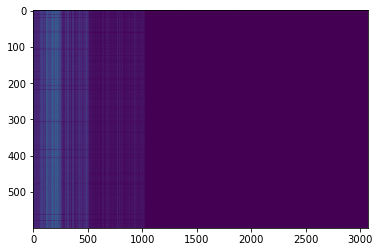

AUC      pAUC
Source_0  0.708000  0.608421
Source_1  0.642900  0.592632
Source_2  0.796500  0.720526
Target_0  0.666600  0.644737
Target_1  0.541500  0.564737
Target_2  0.545800  0.505789
mean      0.650217  0.606140
h_mean    0.638134  0.598938

2021-05-21 23:21:57,742 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:17.707326, val_AUC_hmean:0.638134, val_pAUC_hmean:0.598938, best_flag:True
2021-05-21 23:21:57,743 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.69it/s]
2021-05-21 23:21:58,355 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.36it/s]
2021-05-21 23:21:58,692 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  6.32it/s]
2021-05-21 23:21:59,031 - pytorch_modeler.py - INFO - epoch:233/300, train_losses:17.123854, val_AUC_hmean:0.570222, val_pAUC_hmean:0.579294, best_flag:False
2021-05-21 23:21:59,032 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.05it/s]
2021-05-21 23:21:59,632 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  5.92it/s]
2021-05-21 23:21:59,991 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  5.74it/s]
2021-05-21 23:22:

100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-21 23:22:13,881 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-21 23:22:14,097 - pytorch_modeler.py - INFO - epoch:249/300, train_losses:13.280883, val_AUC_hmean:0.578606, val_pAUC_hmean:0.571410, best_flag:False
2021-05-21 23:22:14,098 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.77it/s]
2021-05-21 23:22:14,566 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:22:14,770 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-21 23:22:14,985 - pytorch_modeler.py - INFO - epoch:250/300, train_losses:12.657009, val_AUC_hmean:0.583253, val_pAUC_hmean:0.575922, best_flag:False
2021-05-21 23:22:14,987 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.14it/s]
2021-05-21 23:22:15,448 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.32it/s]
2021-05-21 23:22:28,555 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.34it/s]
2021-05-21 23:22:28,752 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
2021-05-21 23:22:28,956 - pytorch_modeler.py - INFO - epoch:266/300, train_losses:10.610253, val_AUC_hmean:0.599648, val_pAUC_hmean:0.566814, best_flag:False
2021-05-21 23:22:28,957 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.82it/s]
2021-05-21 23:22:29,407 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-21 23:22:29,603 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:22:29,804 - pytorch_modeler.py - INFO - epoch:267/300, train_losses:9.709631, val_AUC_hmean:0.558049, val_pAUC_hmean:0.570628, best_flag:False
2021-05-21 23:22:29,805 - pytorch_modeler.py - INFO - train
100%|██████████| 

2021-05-21 23:22:43,054 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.17it/s]
2021-05-21 23:22:43,534 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-21 23:22:43,755 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-21 23:22:43,966 - pytorch_modeler.py - INFO - epoch:283/300, train_losses:7.188310, val_AUC_hmean:0.593748, val_pAUC_hmean:0.571091, best_flag:False
2021-05-21 23:22:43,967 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.66it/s]
2021-05-21 23:22:44,456 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.71it/s]
2021-05-21 23:22:44,682 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:22:44,886 - pytorch_modeler.py - INFO - epoch:284/300, train_losses:7.049581, val_AUC_hmean:0.624722, val_pAUC_hmean:0.568695, best_flag:False
2021-05-21 23:22:4

2021-05-21 23:22:57,623 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.45it/s]
2021-05-21 23:22:58,064 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:22:58,260 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.55it/s]
2021-05-21 23:22:58,458 - pytorch_modeler.py - INFO - epoch:300/300, train_losses:5.532358, val_AUC_hmean:0.571583, val_pAUC_hmean:0.566268, best_flag:False
2021-05-21 23:22:58,459 - pytorch_modeler.py - INFO - best model, epoch:232/300, train_losses:17.707326, val_pAUC_hmean:0.598938,


AUC      pAUC
Source_0  0.708000  0.608421
Source_1  0.642900  0.592632
Source_2  0.796500  0.720526
Target_0  0.666600  0.644737
Target_1  0.541500  0.564737
Target_2  0.545800  0.505789
mean      0.650217  0.606140
h_mean    0.638134  0.598938

2021-05-21 23:22:58,466 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-05-21 23:22:58,467 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 23:22:58,501 - 00_train.py - INFO - TRAINING


elapsed time: 283.869205713 [sec]


2021-05-21 23:22:58,697 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 25.79it/s]
2021-05-21 23:22:59,165 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-21 23:22:59,382 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


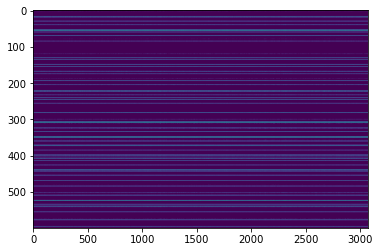

AUC      pAUC
Source_0  0.696300  0.612105
Source_1  0.541500  0.518947
Source_2  0.478700  0.490526
Target_0  0.883750  0.723158
Target_1  0.544200  0.501053
Target_2  0.557800  0.515789
mean      0.617042  0.560263
h_mean    0.592082  0.549616

2021-05-21 23:23:00,438 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1846.883199, val_AUC_hmean:0.592082, val_pAUC_hmean:0.549616, best_flag:True
2021-05-21 23:23:00,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.16it/s]
2021-05-21 23:23:00,882 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:23:01,082 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
2021-05-21 23:23:01,284 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1341.219798, val_AUC_hmean:0.544387, val_pAUC_hmean:0.540990, best_flag:False
2021-05-21 23:23:01,286 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.33it/s]
2021-05-21 23:23:01,744 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-21 23:23:01,942 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.41it/s]
2021-05-21 23:23:

100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:23:15,509 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:23:15,716 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:805.068817, val_AUC_hmean:0.544569, val_pAUC_hmean:0.505368, best_flag:False
2021-05-21 23:23:15,717 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.64it/s]
2021-05-21 23:23:16,188 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:23:16,399 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
2021-05-21 23:23:16,632 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:789.315521, val_AUC_hmean:0.597801, val_pAUC_hmean:0.496244, best_flag:False
2021-05-21 23:23:16,633 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.72it/s]
2021-05-21 23:23:17,102 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.73it/s]
2021-05-21 23:23:30,430 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-21 23:23:30,646 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.41it/s]
2021-05-21 23:23:30,847 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:579.224569, val_AUC_hmean:0.498773, val_pAUC_hmean:0.498008, best_flag:False
2021-05-21 23:23:30,848 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.63it/s]
2021-05-21 23:23:31,285 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.22it/s]
2021-05-21 23:23:31,483 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:23:31,688 - pytorch_modeler.py - INFO - epoch:36/300, train_losses:567.641429, val_AUC_hmean:0.536040, val_pAUC_hmean:0.523806, best_flag:False
2021-05-21 23:23:31,689 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:23:44,803 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.27it/s]
2021-05-21 23:23:45,245 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-21 23:23:45,438 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.72it/s]
2021-05-21 23:23:45,637 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:419.698064, val_AUC_hmean:0.486479, val_pAUC_hmean:0.519064, best_flag:False
2021-05-21 23:23:45,638 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.17it/s]
2021-05-21 23:23:46,099 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:23:46,310 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.28it/s]
2021-05-21 23:23:46,509 - pytorch_modeler.py - INFO - epoch:53/300, train_losses:412.095584, val_AUC_hmean:0.571545, val_pAUC_hmean:0.533531, best_flag:False
2021-05-21 23:23

100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-21 23:23:59,817 - pytorch_modeler.py - INFO - epoch:68/300, train_losses:311.373177, val_AUC_hmean:0.462816, val_pAUC_hmean:0.521360, best_flag:False
2021-05-21 23:23:59,818 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.13it/s]
2021-05-21 23:24:00,263 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.75it/s]
2021-05-21 23:24:00,471 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:24:00,672 - pytorch_modeler.py - INFO - epoch:69/300, train_losses:305.104421, val_AUC_hmean:0.536588, val_pAUC_hmean:0.540101, best_flag:False
2021-05-21 23:24:00,673 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.60it/s]
2021-05-21 23:24:01,127 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.57it/s]
2021-05-21 23:24:01,318 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.92it/s]
2021-05-21 23:24:14,390 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-21 23:24:14,592 - pytorch_modeler.py - INFO - epoch:85/300, train_losses:226.471701, val_AUC_hmean:0.660309, val_pAUC_hmean:0.545619, best_flag:False
2021-05-21 23:24:14,594 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.16it/s]
2021-05-21 23:24:15,074 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
2021-05-21 23:24:15,353 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-21 23:24:15,564 - pytorch_modeler.py - INFO - epoch:86/300, train_losses:222.178387, val_AUC_hmean:0.528389, val_pAUC_hmean:0.541175, best_flag:False
2021-05-21 23:24:15,565 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.04it/s]
2021-05-21 23:24:16,028 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

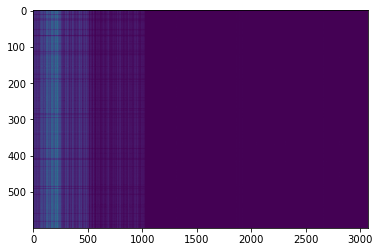

AUC      pAUC
Source_0  0.465100  0.594737
Source_1  0.672200  0.616842
Source_2  0.542700  0.492105
Target_0  0.398900  0.473684
Target_1  0.718700  0.645789
Target_2  0.715900  0.537895
mean      0.585583  0.560175
h_mean    0.556818  0.552824

2021-05-21 23:24:29,741 - pytorch_modeler.py - INFO - epoch:101/300, train_losses:167.866847, val_AUC_hmean:0.556818, val_pAUC_hmean:0.552824, best_flag:True
2021-05-21 23:24:29,741 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.64it/s]
2021-05-21 23:24:30,178 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-21 23:24:30,370 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-21 23:24:30,580 - pytorch_modeler.py - INFO - epoch:102/300, train_losses:164.743849, val_AUC_hmean:0.564118, val_pAUC_hmean:0.534450, best_flag:False
2021-05-21 23:24:30,581 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.20it/s]
2021-05-21 23:24:31,041 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-21 23:24:31,261 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.67it/s]
2021-05-21 23:2

100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-21 23:24:44,343 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-21 23:24:44,541 - pytorch_modeler.py - INFO - epoch:118/300, train_losses:121.663848, val_AUC_hmean:0.569482, val_pAUC_hmean:0.550986, best_flag:False
2021-05-21 23:24:44,542 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.38it/s]
2021-05-21 23:24:44,999 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:24:45,207 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


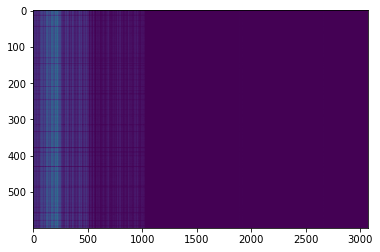

AUC      pAUC
Source_0  0.533300  0.602632
Source_1  0.760400  0.627368
Source_2  0.772100  0.493158
Target_0  0.400900  0.473684
Target_1  0.726900  0.647895
Target_2  0.703900  0.525789
mean      0.649583  0.561754
h_mean    0.613740  0.553630

2021-05-21 23:24:46,301 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:119.464570, val_AUC_hmean:0.613740, val_pAUC_hmean:0.553630, best_flag:True
2021-05-21 23:24:46,302 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.72it/s]
2021-05-21 23:24:46,753 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-21 23:24:46,965 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-21 23:24:47,179 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:117.430435, val_AUC_hmean:0.558972, val_pAUC_hmean:0.546747, best_flag:False
2021-05-21 23:24:47,180 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.13it/s]
2021-05-21 23:24:47,641 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:24:47,849 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:2

100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:25:00,996 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


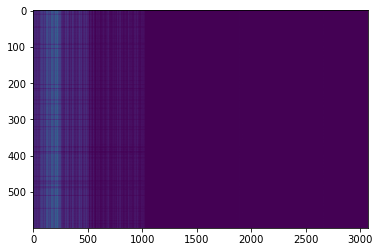

AUC      pAUC
Source_0  0.609100  0.631053
Source_1  0.700000  0.635789
Source_2  0.721000  0.477368
Target_0  0.407400  0.473684
Target_1  0.682400  0.648421
Target_2  0.689800  0.526842
mean      0.634950  0.565526
h_mean    0.610563  0.555363

2021-05-21 23:25:01,974 - pytorch_modeler.py - INFO - epoch:136/300, train_losses:86.139407, val_AUC_hmean:0.610563, val_pAUC_hmean:0.555363, best_flag:True
2021-05-21 23:25:01,975 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.98it/s]
2021-05-21 23:25:02,477 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.33it/s]
2021-05-21 23:25:02,713 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-21 23:25:02,934 - pytorch_modeler.py - INFO - epoch:137/300, train_losses:84.838268, val_AUC_hmean:0.525411, val_pAUC_hmean:0.532325, best_flag:False
2021-05-21 23:25:02,935 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.14it/s]
2021-05-21 23:25:03,435 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:25:03,637 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.38it/s]
2021-05-21 23:25:

100%|██████████| 2/2 [00:00<00:00, 10.16it/s]
2021-05-21 23:25:16,980 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-21 23:25:17,191 - pytorch_modeler.py - INFO - epoch:153/300, train_losses:62.576008, val_AUC_hmean:0.638135, val_pAUC_hmean:0.534159, best_flag:False
2021-05-21 23:25:17,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.19it/s]
2021-05-21 23:25:17,714 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-21 23:25:17,929 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]
2021-05-21 23:25:18,134 - pytorch_modeler.py - INFO - epoch:154/300, train_losses:61.440301, val_AUC_hmean:0.498612, val_pAUC_hmean:0.524503, best_flag:False
2021-05-21 23:25:18,135 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.64it/s]
2021-05-21 23:25:18,645 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.85it/s]
2021-05-21 23:25:32,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.45it/s]
2021-05-21 23:25:32,295 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.81it/s]
2021-05-21 23:25:32,558 - pytorch_modeler.py - INFO - epoch:170/300, train_losses:45.838466, val_AUC_hmean:0.510367, val_pAUC_hmean:0.531994, best_flag:False
2021-05-21 23:25:32,560 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.51it/s]
2021-05-21 23:25:33,053 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-21 23:25:33,255 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
2021-05-21 23:25:33,488 - pytorch_modeler.py - INFO - epoch:171/300, train_losses:44.632334, val_AUC_hmean:0.497051, val_pAUC_hmean:0.541242, best_flag:False
2021-05-21 23:25:33,489 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:25:46,442 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.56it/s]
2021-05-21 23:25:46,880 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-21 23:25:47,089 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-21 23:25:47,291 - pytorch_modeler.py - INFO - epoch:187/300, train_losses:32.868666, val_AUC_hmean:0.501512, val_pAUC_hmean:0.530180, best_flag:False
2021-05-21 23:25:47,292 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.15it/s]
2021-05-21 23:25:47,754 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:25:47,955 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-21 23:25:48,157 - pytorch_modeler.py - INFO - epoch:188/300, train_losses:31.543707, val_AUC_hmean:0.481715, val_pAUC_hmean:0.537853, best_flag:False
2021-05-21 23:25

100%|██████████| 2/2 [00:00<00:00,  9.57it/s]
2021-05-21 23:26:01,376 - pytorch_modeler.py - INFO - epoch:203/300, train_losses:23.473804, val_AUC_hmean:0.557169, val_pAUC_hmean:0.552993, best_flag:False
2021-05-21 23:26:01,378 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.58it/s]
2021-05-21 23:26:01,831 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.11it/s]
2021-05-21 23:26:02,031 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:26:02,238 - pytorch_modeler.py - INFO - epoch:204/300, train_losses:22.775702, val_AUC_hmean:0.581002, val_pAUC_hmean:0.551657, best_flag:False
2021-05-21 23:26:02,239 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.33it/s]
2021-05-21 23:26:02,681 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-21 23:26:02,888 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-21 23:26:15,827 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:26:16,027 - pytorch_modeler.py - INFO - epoch:220/300, train_losses:16.798318, val_AUC_hmean:0.523655, val_pAUC_hmean:0.550779, best_flag:False
2021-05-21 23:26:16,029 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.32it/s]
2021-05-21 23:26:16,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
2021-05-21 23:26:16,668 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
2021-05-21 23:26:16,869 - pytorch_modeler.py - INFO - epoch:221/300, train_losses:16.596834, val_AUC_hmean:0.551154, val_pAUC_hmean:0.548017, best_flag:False
2021-05-21 23:26:16,870 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.80it/s]
2021-05-21 23:26:17,321 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

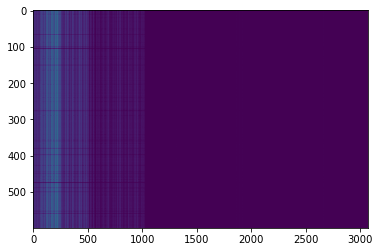

AUC      pAUC
Source_0  0.600400  0.605263
Source_1  0.691900  0.667368
Source_2  0.797500  0.474737
Target_0  0.327600  0.473684
Target_1  0.715800  0.665789
Target_2  0.631600  0.524737
mean      0.627467  0.568596
h_mean    0.577057  0.556802

2021-05-21 23:26:18,541 - pytorch_modeler.py - INFO - epoch:222/300, train_losses:16.305625, val_AUC_hmean:0.577057, val_pAUC_hmean:0.556802, best_flag:True
2021-05-21 23:26:18,542 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.20it/s]
2021-05-21 23:26:19,002 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-21 23:26:19,218 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.08it/s]
2021-05-21 23:26:19,424 - pytorch_modeler.py - INFO - epoch:223/300, train_losses:15.666706, val_AUC_hmean:0.586322, val_pAUC_hmean:0.546315, best_flag:False
2021-05-21 23:26:19,425 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-05-21 23:26:19,875 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.11it/s]
2021-05-21 23:26:20,093 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-21 23:26:

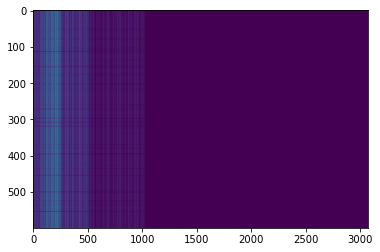

AUC      pAUC
Source_0  0.824800  0.661053
Source_1  0.699000  0.635789
Source_2  0.837100  0.474211
Target_0  0.332600  0.473684
Target_1  0.714900  0.644737
Target_2  0.643500  0.528421
mean      0.675317  0.569649
h_mean    0.612430  0.558196

2021-05-21 23:26:28,122 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:13.491294, val_AUC_hmean:0.612430, val_pAUC_hmean:0.558196, best_flag:True
2021-05-21 23:26:28,123 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.81it/s]
2021-05-21 23:26:28,590 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.00it/s]
2021-05-21 23:26:28,833 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-21 23:26:29,035 - pytorch_modeler.py - INFO - epoch:233/300, train_losses:12.886134, val_AUC_hmean:0.559864, val_pAUC_hmean:0.551114, best_flag:False
2021-05-21 23:26:29,036 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.12it/s]
2021-05-21 23:26:29,497 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:26:29,705 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.38it/s]
2021-05-21 23:26:

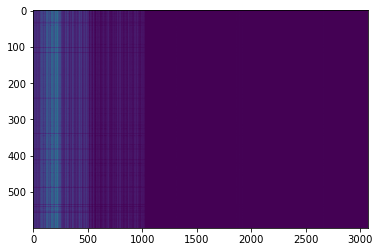

AUC      pAUC
Source_0  0.676800  0.614211
Source_1  0.693700  0.652632
Source_2  0.782300  0.473684
Target_0  0.316800  0.473684
Target_1  0.705100  0.662632
Target_2  0.675100  0.542105
mean      0.641633  0.569825
h_mean    0.585170  0.558848

2021-05-21 23:26:37,667 - pytorch_modeler.py - INFO - epoch:242/300, train_losses:10.989885, val_AUC_hmean:0.585170, val_pAUC_hmean:0.558848, best_flag:True
2021-05-21 23:26:37,667 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.43it/s]
2021-05-21 23:26:38,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-21 23:26:38,322 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
2021-05-21 23:26:38,518 - pytorch_modeler.py - INFO - epoch:243/300, train_losses:10.556554, val_AUC_hmean:0.590196, val_pAUC_hmean:0.550020, best_flag:False
2021-05-21 23:26:38,520 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.57it/s]
2021-05-21 23:26:38,975 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-21 23:26:39,177 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
2021-05-21 23:26:

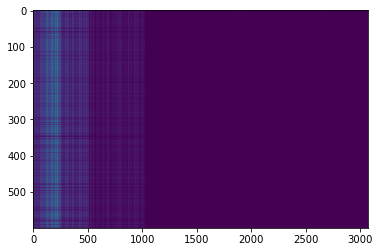

AUC      pAUC
Source_0  0.677700  0.634211
Source_1  0.716400  0.657895
Source_2  0.799000  0.473684
Target_0  0.260200  0.473684
Target_1  0.667900  0.648421
Target_2  0.670400  0.545789
mean      0.631933  0.572281
h_mean    0.547691  0.561094

2021-05-21 23:26:42,754 - pytorch_modeler.py - INFO - epoch:247/300, train_losses:9.928266, val_AUC_hmean:0.547691, val_pAUC_hmean:0.561094, best_flag:True
2021-05-21 23:26:42,755 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.09it/s]
2021-05-21 23:26:43,218 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:26:43,421 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
2021-05-21 23:26:43,622 - pytorch_modeler.py - INFO - epoch:248/300, train_losses:9.686921, val_AUC_hmean:0.548212, val_pAUC_hmean:0.547569, best_flag:False
2021-05-21 23:26:43,623 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.50it/s]
2021-05-21 23:26:44,078 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
2021-05-21 23:26:44,339 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:26:44

100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-21 23:26:57,141 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.42it/s]
2021-05-21 23:26:57,341 - pytorch_modeler.py - INFO - epoch:264/300, train_losses:6.957743, val_AUC_hmean:0.578197, val_pAUC_hmean:0.552201, best_flag:False
2021-05-21 23:26:57,342 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.14it/s]
2021-05-21 23:26:57,787 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:26:57,983 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-21 23:26:58,184 - pytorch_modeler.py - INFO - epoch:265/300, train_losses:6.925678, val_AUC_hmean:0.605178, val_pAUC_hmean:0.539151, best_flag:False
2021-05-21 23:26:58,186 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.96it/s]
2021-05-21 23:26:58,633 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

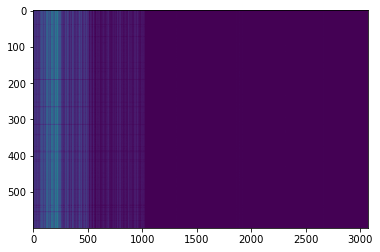

AUC      pAUC
Source_0  0.727200  0.745789
Source_1  0.725700  0.658947
Source_2  0.699000  0.474211
Target_0  0.294200  0.473684
Target_1  0.668200  0.653684
Target_2  0.671700  0.538421
mean      0.631000  0.590789
h_mean    0.567746  0.573319

2021-05-21 23:27:07,541 - pytorch_modeler.py - INFO - epoch:275/300, train_losses:5.645995, val_AUC_hmean:0.567746, val_pAUC_hmean:0.573319, best_flag:True
2021-05-21 23:27:07,542 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.67it/s]
2021-05-21 23:27:07,994 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.39it/s]
2021-05-21 23:27:08,189 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-21 23:27:08,390 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:5.610272, val_AUC_hmean:0.568281, val_pAUC_hmean:0.551381, best_flag:False
2021-05-21 23:27:08,391 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.63it/s]
2021-05-21 23:27:08,844 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.25it/s]
2021-05-21 23:27:09,061 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.12it/s]
2021-05-21 23:27:09

100%|██████████| 2/2 [00:00<00:00, 10.00it/s]
2021-05-21 23:27:22,536 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.15it/s]
2021-05-21 23:27:22,738 - pytorch_modeler.py - INFO - epoch:292/300, train_losses:4.195930, val_AUC_hmean:0.637405, val_pAUC_hmean:0.553233, best_flag:False
2021-05-21 23:27:22,739 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.56it/s]
2021-05-21 23:27:23,193 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:27:23,396 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-21 23:27:23,606 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:4.265134, val_AUC_hmean:0.610663, val_pAUC_hmean:0.543341, best_flag:False
2021-05-21 23:27:23,608 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.20it/s]
2021-05-21 23:27:24,086 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

AUC      pAUC
Source_0  0.727200  0.745789
Source_1  0.725700  0.658947
Source_2  0.699000  0.474211
Target_0  0.294200  0.473684
Target_1  0.668200  0.653684
Target_2  0.671700  0.538421
mean      0.631000  0.590789
h_mean    0.567746  0.573319

2021-05-21 23:27:29,896 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-05-21 23:27:29,897 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-21 23:27:29,932 - 00_train.py - INFO - TRAINING


elapsed time: 271.429681540 [sec]


2021-05-21 23:27:30,128 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 26.54it/s]
2021-05-21 23:27:30,583 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-21 23:27:30,783 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


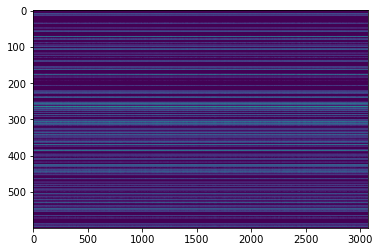

AUC      pAUC
Source_0  0.566700  0.571053
Source_1  0.200000  0.473684
Source_2  0.623900  0.552105
Target_0  0.582900  0.539474
Target_1  0.334100  0.502105
Target_2  0.548100  0.528421
mean      0.475950  0.527807
h_mean    0.402669  0.525799

2021-05-21 23:27:31,840 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2089.758982, val_AUC_hmean:0.402669, val_pAUC_hmean:0.525799, best_flag:True
2021-05-21 23:27:31,841 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.01it/s]
2021-05-21 23:27:32,343 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-21 23:27:32,562 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:27:32,775 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1461.730275, val_AUC_hmean:0.524780, val_pAUC_hmean:0.509261, best_flag:False
2021-05-21 23:27:32,776 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.58it/s]
2021-05-21 23:27:33,230 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:27:33,433 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


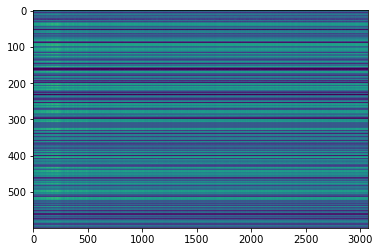

AUC      pAUC
Source_0  0.614200  0.588947
Source_1  0.573400  0.561053
Source_2  0.504000  0.514211
Target_0  0.495200  0.485789
Target_1  0.701600  0.607895
Target_2  0.466900  0.500000
mean      0.559217  0.542982
h_mean    0.548309  0.539153

2021-05-21 23:27:34,437 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1308.051829, val_AUC_hmean:0.548309, val_pAUC_hmean:0.539153, best_flag:True
2021-05-21 23:27:34,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.42it/s]
2021-05-21 23:27:34,912 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-21 23:27:35,136 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.32it/s]
2021-05-21 23:27:35,356 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1234.290192, val_AUC_hmean:0.592684, val_pAUC_hmean:0.537296, best_flag:False
2021-05-21 23:27:35,357 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.35it/s]
2021-05-21 23:27:35,832 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-21 23:27:36,047 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:27:

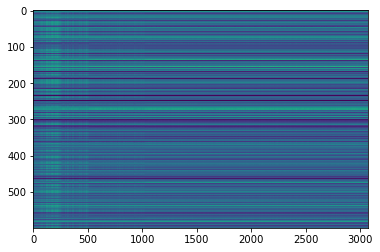

AUC      pAUC
Source_0  0.523700  0.551579
Source_1  0.832600  0.635263
Source_2  0.610000  0.582632
Target_0  0.551700  0.513158
Target_1  0.548500  0.490000
Target_2  0.505800  0.514211
mean      0.595383  0.547807
h_mean    0.579000  0.543589

2021-05-21 23:27:38,006 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1129.552175, val_AUC_hmean:0.579000, val_pAUC_hmean:0.543589, best_flag:True
2021-05-21 23:27:38,007 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.21it/s]
2021-05-21 23:27:38,467 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.93it/s]
2021-05-21 23:27:38,715 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.00it/s]
2021-05-21 23:27:38,937 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1079.560435, val_AUC_hmean:0.596949, val_pAUC_hmean:0.536585, best_flag:False
2021-05-21 23:27:38,939 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.21it/s]
2021-05-21 23:27:39,382 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
2021-05-21 23:27:39,590 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.97it/s]
2021-05-21 23:27:

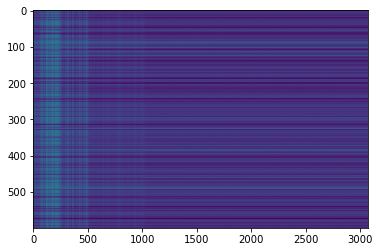

AUC      pAUC
Source_0  0.539800  0.553158
Source_1  0.801800  0.746316
Source_2  0.620900  0.539474
Target_0  0.600900  0.538421
Target_1  0.449200  0.498947
Target_2  0.486500  0.505789
mean      0.583183  0.563684
h_mean    0.563055  0.553506

2021-05-21 23:27:44,296 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:924.427795, val_AUC_hmean:0.563055, val_pAUC_hmean:0.553506, best_flag:True
2021-05-21 23:27:44,297 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.14it/s]
2021-05-21 23:27:44,797 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-21 23:27:45,017 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.25it/s]
2021-05-21 23:27:45,236 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:897.761566, val_AUC_hmean:0.575763, val_pAUC_hmean:0.535106, best_flag:False
2021-05-21 23:27:45,238 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.25it/s]
2021-05-21 23:27:45,715 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-21 23:27:45,927 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-21 23:27:

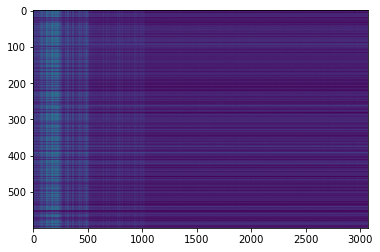

AUC      pAUC
Source_0  0.53780  0.594737
Source_1  0.81760  0.654211
Source_2  0.68720  0.575263
Target_0  0.53910  0.524211
Target_1  0.46210  0.495789
Target_2  0.51420  0.511579
mean      0.59300  0.559298
h_mean    0.57135  0.554136

2021-05-21 23:27:47,873 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:846.383809, val_AUC_hmean:0.571350, val_pAUC_hmean:0.554136, best_flag:True
2021-05-21 23:27:47,874 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.04it/s]
2021-05-21 23:27:48,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-21 23:27:48,586 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-21 23:27:48,811 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:825.147298, val_AUC_hmean:0.612496, val_pAUC_hmean:0.544530, best_flag:False
2021-05-21 23:27:48,812 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.69it/s]
2021-05-21 23:27:49,301 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-21 23:27:49,533 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.29it/s]
2021-05-21 23:27:

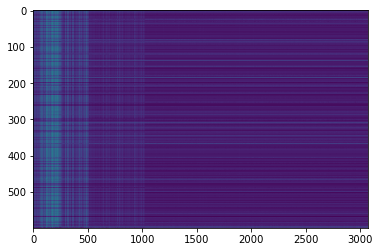

AUC      pAUC
Source_0  0.561100  0.616842
Source_1  0.770500  0.684737
Source_2  0.708400  0.569474
Target_0  0.498300  0.530526
Target_1  0.518900  0.501579
Target_2  0.546000  0.514737
mean      0.600533  0.569649
h_mean    0.584956  0.562907

2021-05-21 23:27:51,743 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:786.508931, val_AUC_hmean:0.584956, val_pAUC_hmean:0.562907, best_flag:True
2021-05-21 23:27:51,744 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.31it/s]
2021-05-21 23:27:52,204 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-21 23:27:52,424 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-21 23:27:52,643 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:766.526438, val_AUC_hmean:0.604256, val_pAUC_hmean:0.559547, best_flag:False
2021-05-21 23:27:52,645 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.91it/s]
2021-05-21 23:27:53,093 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-21 23:27:53,307 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-21 23:27:

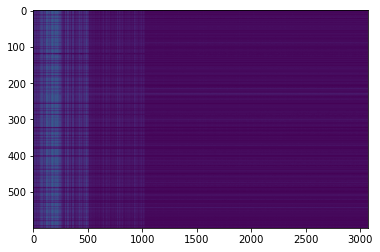

AUC      pAUC
Source_0  0.604700  0.618947
Source_1  0.823900  0.652105
Source_2  0.727800  0.615789
Target_0  0.558400  0.527368
Target_1  0.575900  0.498421
Target_2  0.503900  0.505263
mean      0.632433  0.569649
h_mean    0.615181  0.563127

2021-05-21 23:27:56,177 - pytorch_modeler.py - INFO - epoch:22/300, train_losses:707.935135, val_AUC_hmean:0.615181, val_pAUC_hmean:0.563127, best_flag:True
2021-05-21 23:27:56,178 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.85it/s]
2021-05-21 23:27:56,645 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-21 23:27:56,853 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:27:57,061 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:696.000656, val_AUC_hmean:0.612749, val_pAUC_hmean:0.561200, best_flag:False
2021-05-21 23:27:57,063 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.64it/s]
2021-05-21 23:27:57,552 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 23:27:57,762 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-21 23:27:

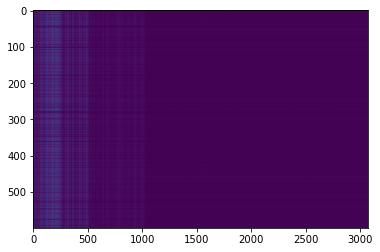

AUC      pAUC
Source_0  0.606800  0.593684
Source_1  0.854800  0.678421
Source_2  0.704300  0.613158
Target_0  0.548500  0.537368
Target_1  0.562700  0.483684
Target_2  0.529400  0.517368
mean      0.634417  0.570614
h_mean    0.616844  0.563351

2021-05-21 23:28:02,503 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:622.068939, val_AUC_hmean:0.616844, val_pAUC_hmean:0.563351, best_flag:True
2021-05-21 23:28:02,504 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.55it/s]
2021-05-21 23:28:03,016 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.92it/s]
2021-05-21 23:28:03,263 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-21 23:28:03,473 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:608.709340, val_AUC_hmean:0.627674, val_pAUC_hmean:0.562983, best_flag:False
2021-05-21 23:28:03,474 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.51it/s]
2021-05-21 23:28:03,967 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.47it/s]
2021-05-21 23:28:04,182 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


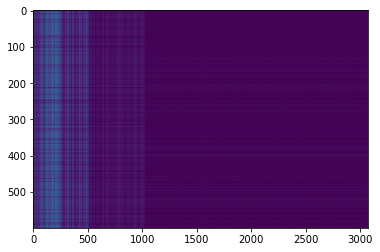

AUC      pAUC
Source_0  0.601000  0.596316
Source_1  0.850100  0.720526
Source_2  0.699600  0.592632
Target_0  0.537200  0.560526
Target_1  0.633900  0.512632
Target_2  0.539700  0.521579
mean      0.643583  0.584035
h_mean    0.627514  0.576688

2021-05-21 23:28:05,311 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:595.721522, val_AUC_hmean:0.627514, val_pAUC_hmean:0.576688, best_flag:True
2021-05-21 23:28:05,312 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.21it/s]
2021-05-21 23:28:05,810 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
2021-05-21 23:28:06,035 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
2021-05-21 23:28:06,260 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:586.855881, val_AUC_hmean:0.645613, val_pAUC_hmean:0.571725, best_flag:False
2021-05-21 23:28:06,261 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.03it/s]
2021-05-21 23:28:06,725 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:28:06,935 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


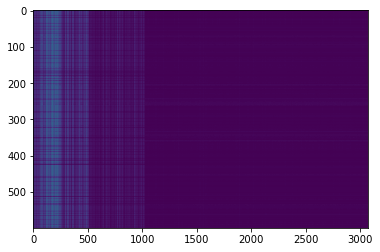

AUC      pAUC
Source_0  0.572000  0.606842
Source_1  0.866700  0.713158
Source_2  0.744800  0.609474
Target_0  0.522100  0.555263
Target_1  0.692600  0.614211
Target_2  0.534000  0.527368
mean      0.655367  0.604386
h_mean    0.633143  0.599035

2021-05-21 23:28:08,006 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:575.595840, val_AUC_hmean:0.633143, val_pAUC_hmean:0.599035, best_flag:True
2021-05-21 23:28:08,007 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.06it/s]
2021-05-21 23:28:08,488 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-21 23:28:08,714 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.44it/s]
2021-05-21 23:28:08,950 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:560.706156, val_AUC_hmean:0.617435, val_pAUC_hmean:0.586992, best_flag:False
2021-05-21 23:28:08,951 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:28:09,429 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-21 23:28:09,645 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-21 23:28:

100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-21 23:28:23,393 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]
2021-05-21 23:28:23,595 - pytorch_modeler.py - INFO - epoch:49/300, train_losses:410.076174, val_AUC_hmean:0.670118, val_pAUC_hmean:0.580303, best_flag:False
2021-05-21 23:28:23,596 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.30it/s]
2021-05-21 23:28:24,055 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.43it/s]
2021-05-21 23:28:24,273 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-21 23:28:24,523 - pytorch_modeler.py - INFO - epoch:50/300, train_losses:402.462769, val_AUC_hmean:0.652548, val_pAUC_hmean:0.575697, best_flag:False
2021-05-21 23:28:24,524 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:28:25,003 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

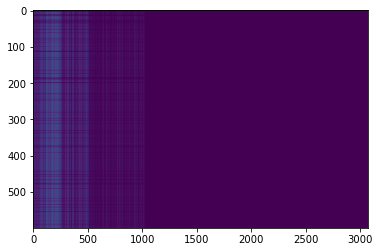

AUC      pAUC
Source_0  0.645400  0.617368
Source_1  0.848200  0.665789
Source_2  0.717400  0.611579
Target_0  0.636100  0.561579
Target_1  0.672200  0.643158
Target_2  0.529700  0.520000
mean      0.674833  0.603246
h_mean    0.661528  0.599074

2021-05-21 23:28:30,813 - pytorch_modeler.py - INFO - epoch:56/300, train_losses:360.474035, val_AUC_hmean:0.661528, val_pAUC_hmean:0.599074, best_flag:True
2021-05-21 23:28:30,814 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 18.23it/s]
2021-05-21 23:28:31,475 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  5.88it/s]
2021-05-21 23:28:31,836 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  5.91it/s]
2021-05-21 23:28:32,200 - pytorch_modeler.py - INFO - epoch:57/300, train_losses:358.478981, val_AUC_hmean:0.631936, val_pAUC_hmean:0.583160, best_flag:False
2021-05-21 23:28:32,202 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.32it/s]
2021-05-21 23:28:32,826 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  5.92it/s]
2021-05-21 23:28:33,186 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  5.83it/s]
2021-05-21 23:28:

100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:28:47,067 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-21 23:28:47,272 - pytorch_modeler.py - INFO - epoch:73/300, train_losses:257.249282, val_AUC_hmean:0.644729, val_pAUC_hmean:0.584864, best_flag:False
2021-05-21 23:28:47,273 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.00it/s]
2021-05-21 23:28:47,778 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:28:47,988 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:28:48,190 - pytorch_modeler.py - INFO - epoch:74/300, train_losses:251.435919, val_AUC_hmean:0.647629, val_pAUC_hmean:0.578443, best_flag:False
2021-05-21 23:28:48,191 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.57it/s]
2021-05-21 23:28:48,645 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.11it/s]
2021-05-21 23:29:01,844 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-21 23:29:02,041 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:29:02,247 - pytorch_modeler.py - INFO - epoch:90/300, train_losses:184.651324, val_AUC_hmean:0.662004, val_pAUC_hmean:0.582366, best_flag:False
2021-05-21 23:29:02,248 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.43it/s]
2021-05-21 23:29:02,687 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]
2021-05-21 23:29:02,888 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.10it/s]
2021-05-21 23:29:03,130 - pytorch_modeler.py - INFO - epoch:91/300, train_losses:181.351075, val_AUC_hmean:0.639832, val_pAUC_hmean:0.580779, best_flag:False
2021-05-21 23:29:03,131 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:29:16,297 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.68it/s]
2021-05-21 23:29:16,767 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
2021-05-21 23:29:16,997 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.77it/s]
2021-05-21 23:29:17,208 - pytorch_modeler.py - INFO - epoch:107/300, train_losses:136.864829, val_AUC_hmean:0.638702, val_pAUC_hmean:0.586936, best_flag:False
2021-05-21 23:29:17,209 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.64it/s]
2021-05-21 23:29:17,700 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.10it/s]
2021-05-21 23:29:17,943 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:29:18,143 - pytorch_modeler.py - INFO - epoch:108/300, train_losses:133.426023, val_AUC_hmean:0.635069, val_pAUC_hmean:0.592994, best_flag:False
2021-05-21 23:

100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:29:31,451 - pytorch_modeler.py - INFO - epoch:123/300, train_losses:97.307273, val_AUC_hmean:0.654619, val_pAUC_hmean:0.588737, best_flag:False
2021-05-21 23:29:31,454 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.37it/s]
2021-05-21 23:29:31,911 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:29:32,117 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-21 23:29:32,319 - pytorch_modeler.py - INFO - epoch:124/300, train_losses:95.282944, val_AUC_hmean:0.641377, val_pAUC_hmean:0.575736, best_flag:False
2021-05-21 23:29:32,320 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.54it/s]
2021-05-21 23:29:32,793 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.75it/s]
2021-05-21 23:29:33,025 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
2021-05-21 23:29:46,217 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
2021-05-21 23:29:46,414 - pytorch_modeler.py - INFO - epoch:140/300, train_losses:69.990475, val_AUC_hmean:0.667998, val_pAUC_hmean:0.579776, best_flag:False
2021-05-21 23:29:46,416 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.14it/s]
2021-05-21 23:29:46,860 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:29:47,064 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.65it/s]
2021-05-21 23:29:47,278 - pytorch_modeler.py - INFO - epoch:141/300, train_losses:67.446903, val_AUC_hmean:0.658899, val_pAUC_hmean:0.582979, best_flag:False
2021-05-21 23:29:47,279 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.02it/s]
2021-05-21 23:29:47,760 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 25.53it/s]
2021-05-21 23:30:01,539 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-21 23:30:01,759 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:30:01,972 - pytorch_modeler.py - INFO - epoch:157/300, train_losses:49.101764, val_AUC_hmean:0.651458, val_pAUC_hmean:0.590910, best_flag:False
2021-05-21 23:30:01,973 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.55it/s]
2021-05-21 23:30:02,466 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-21 23:30:02,687 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:30:02,891 - pytorch_modeler.py - INFO - epoch:158/300, train_losses:47.911280, val_AUC_hmean:0.654359, val_pAUC_hmean:0.582324, best_flag:False
2021-05-21 23:30:02,893 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:30:16,162 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.66it/s]
2021-05-21 23:30:16,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.20it/s]
2021-05-21 23:30:16,890 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:30:17,091 - pytorch_modeler.py - INFO - epoch:174/300, train_losses:33.631230, val_AUC_hmean:0.660253, val_pAUC_hmean:0.587114, best_flag:False
2021-05-21 23:30:17,092 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.60it/s]
2021-05-21 23:30:17,546 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:30:17,747 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
2021-05-21 23:30:17,951 - pytorch_modeler.py - INFO - epoch:175/300, train_losses:32.767456, val_AUC_hmean:0.668327, val_pAUC_hmean:0.584762, best_flag:False
2021-05-21 23:30

100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-21 23:30:31,103 - pytorch_modeler.py - INFO - epoch:190/300, train_losses:24.392455, val_AUC_hmean:0.669213, val_pAUC_hmean:0.590823, best_flag:False
2021-05-21 23:30:31,104 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-21 23:30:31,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:30:31,775 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.52it/s]
2021-05-21 23:30:31,975 - pytorch_modeler.py - INFO - epoch:191/300, train_losses:25.038498, val_AUC_hmean:0.649183, val_pAUC_hmean:0.590704, best_flag:False
2021-05-21 23:30:31,976 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.89it/s]
2021-05-21 23:30:32,425 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.38it/s]
2021-05-21 23:30:32,619 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 11.11it/s]
2021-05-21 23:30:45,828 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.42it/s]
2021-05-21 23:30:46,029 - pytorch_modeler.py - INFO - epoch:207/300, train_losses:23.399851, val_AUC_hmean:0.648044, val_pAUC_hmean:0.581764, best_flag:False
2021-05-21 23:30:46,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.52it/s]
2021-05-21 23:30:46,485 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:30:46,684 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:30:46,891 - pytorch_modeler.py - INFO - epoch:208/300, train_losses:29.844769, val_AUC_hmean:0.635425, val_pAUC_hmean:0.589586, best_flag:False
2021-05-21 23:30:46,892 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.12it/s]
2021-05-21 23:30:47,337 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-05-21 23:31:00,425 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:31:00,626 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:31:00,834 - pytorch_modeler.py - INFO - epoch:224/300, train_losses:16.941598, val_AUC_hmean:0.613205, val_pAUC_hmean:0.548851, best_flag:False
2021-05-21 23:31:00,835 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.91it/s]
2021-05-21 23:31:01,301 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.48it/s]
2021-05-21 23:31:01,514 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-21 23:31:01,717 - pytorch_modeler.py - INFO - epoch:225/300, train_losses:16.082454, val_AUC_hmean:0.639370, val_pAUC_hmean:0.576513, best_flag:False
2021-05-21 23:31:01,718 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:31:15,491 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.40it/s]
2021-05-21 23:31:15,986 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-21 23:31:16,197 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.75it/s]
2021-05-21 23:31:16,409 - pytorch_modeler.py - INFO - epoch:241/300, train_losses:8.951411, val_AUC_hmean:0.635977, val_pAUC_hmean:0.578285, best_flag:False
2021-05-21 23:31:16,410 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.72it/s]
2021-05-21 23:31:16,879 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-21 23:31:17,097 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-21 23:31:17,321 - pytorch_modeler.py - INFO - epoch:242/300, train_losses:8.281316, val_AUC_hmean:0.627327, val_pAUC_hmean:0.574025, best_flag:False
2021-05-21 23:31:1

2021-05-21 23:31:31,371 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.12it/s]
2021-05-21 23:31:31,833 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
2021-05-21 23:31:32,070 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
2021-05-21 23:31:32,291 - pytorch_modeler.py - INFO - epoch:258/300, train_losses:5.818432, val_AUC_hmean:0.638248, val_pAUC_hmean:0.577026, best_flag:False
2021-05-21 23:31:32,292 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.85it/s]
2021-05-21 23:31:32,759 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.92it/s]
2021-05-21 23:31:32,961 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-21 23:31:33,172 - pytorch_modeler.py - INFO - epoch:259/300, train_losses:5.671899, val_AUC_hmean:0.647944, val_pAUC_hmean:0.579723, best_flag:False
2021-05-21 23:31:3

2021-05-21 23:31:46,503 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.34it/s]
2021-05-21 23:31:46,978 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.21it/s]
2021-05-21 23:31:47,222 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-21 23:31:47,447 - pytorch_modeler.py - INFO - epoch:275/300, train_losses:4.267672, val_AUC_hmean:0.640772, val_pAUC_hmean:0.576914, best_flag:False
2021-05-21 23:31:47,448 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.08it/s]
2021-05-21 23:31:47,929 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:31:48,132 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.31it/s]
2021-05-21 23:31:48,333 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:4.018573, val_AUC_hmean:0.625571, val_pAUC_hmean:0.578436, best_flag:False
2021-05-21 23:31:4

2021-05-21 23:32:01,951 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.92it/s]
2021-05-21 23:32:02,399 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-21 23:32:02,596 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:32:02,812 - pytorch_modeler.py - INFO - epoch:292/300, train_losses:3.252211, val_AUC_hmean:0.629463, val_pAUC_hmean:0.579996, best_flag:False
2021-05-21 23:32:02,814 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.99it/s]
2021-05-21 23:32:03,261 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-21 23:32:03,469 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.21it/s]
2021-05-21 23:32:03,669 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:3.337481, val_AUC_hmean:0.634220, val_pAUC_hmean:0.575138, best_flag:False
2021-05-21 23:32:0

AUC      pAUC
Source_0  0.645400  0.617368
Source_1  0.848200  0.665789
Source_2  0.717400  0.611579
Target_0  0.636100  0.561579
Target_1  0.672200  0.643158
Target_2  0.529700  0.520000
mean      0.674833  0.603246
h_mean    0.661528  0.599074

2021-05-21 23:32:09,992 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-05-21 23:32:09,993 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 280.094838381 [sec]


2021-05-21 23:32:10,509 - 00_train.py - INFO - TRAINING
2021-05-21 23:32:10,709 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 23.17it/s]
2021-05-21 23:32:11,230 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.07it/s]
2021-05-21 23:32:11,452 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


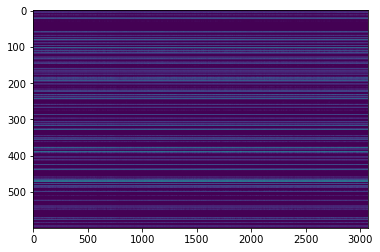

AUC      pAUC
Source_0  0.525700  0.496842
Source_1  0.413400  0.487895
Source_2  0.510600  0.492105
Target_0  0.563500  0.533158
Target_1  0.492300  0.488421
Target_2  0.529200  0.520000
mean      0.505783  0.503070
h_mean    0.501035  0.502490

2021-05-21 23:32:12,448 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:2181.237427, val_AUC_hmean:0.501035, val_pAUC_hmean:0.502490, best_flag:True
2021-05-21 23:32:12,449 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.08it/s]
2021-05-21 23:32:12,911 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:32:13,119 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:32:13,325 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1521.038228, val_AUC_hmean:0.462584, val_pAUC_hmean:0.492156, best_flag:False
2021-05-21 23:32:13,327 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.36it/s]
2021-05-21 23:32:13,784 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-21 23:32:14,005 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.41it/s]
2021-05-21 23:32:

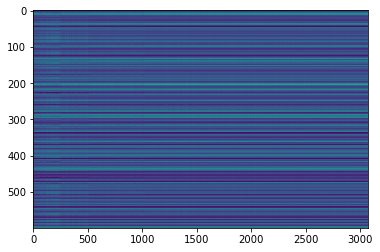

AUC      pAUC
Source_0  0.600700  0.524211
Source_1  0.424000  0.501579
Source_2  0.481900  0.502105
Target_0  0.532100  0.532632
Target_1  0.494000  0.500526
Target_2  0.461600  0.504737
mean      0.499050  0.510965
h_mean    0.493082  0.510658

2021-05-21 23:32:15,892 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1218.456167, val_AUC_hmean:0.493082, val_pAUC_hmean:0.510658, best_flag:True
2021-05-21 23:32:15,893 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.53it/s]
2021-05-21 23:32:16,365 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
2021-05-21 23:32:16,564 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]


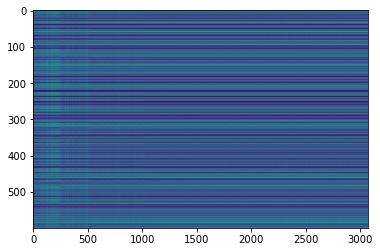

AUC      pAUC
Source_0  0.634400  0.524211
Source_1  0.640900  0.517368
Source_2  0.421400  0.513684
Target_0  0.700900  0.556842
Target_1  0.450200  0.486842
Target_2  0.477800  0.475789
mean      0.554267  0.512456
h_mean    0.533308  0.511122

2021-05-21 23:32:17,686 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:1153.976044, val_AUC_hmean:0.533308, val_pAUC_hmean:0.511122, best_flag:True
2021-05-21 23:32:17,687 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.77it/s]
2021-05-21 23:32:18,155 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.50it/s]
2021-05-21 23:32:18,375 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


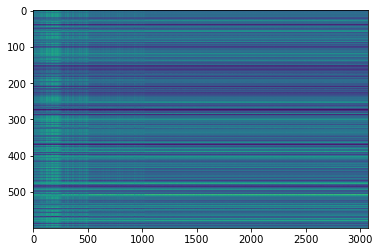

AUC      pAUC
Source_0  0.654200  0.531579
Source_1  0.717200  0.528947
Source_2  0.485800  0.523684
Target_0  0.771100  0.543684
Target_1  0.509500  0.500526
Target_2  0.434200  0.481053
mean      0.595333  0.518246
h_mean    0.569044  0.517364

2021-05-21 23:32:19,552 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1096.609507, val_AUC_hmean:0.569044, val_pAUC_hmean:0.517364, best_flag:True
2021-05-21 23:32:19,554 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.50it/s]
2021-05-21 23:32:20,046 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-21 23:32:20,249 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


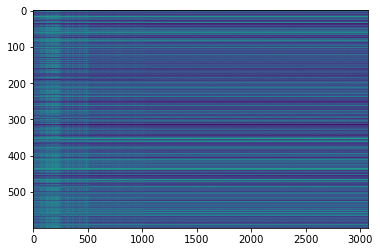

AUC      pAUC
Source_0  0.715600  0.578947
Source_1  0.705100  0.528947
Source_2  0.491800  0.498947
Target_0  0.765300  0.602105
Target_1  0.532600  0.515789
Target_2  0.481700  0.494737
mean      0.615350  0.536579
h_mean    0.593516  0.533669

2021-05-21 23:32:21,272 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1058.918823, val_AUC_hmean:0.593516, val_pAUC_hmean:0.533669, best_flag:True
2021-05-21 23:32:21,273 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.70it/s]
2021-05-21 23:32:21,742 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:32:21,960 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-21 23:32:22,168 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:1013.464823, val_AUC_hmean:0.584615, val_pAUC_hmean:0.530771, best_flag:False
2021-05-21 23:32:22,170 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.29it/s]
2021-05-21 23:32:22,628 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:32:22,829 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


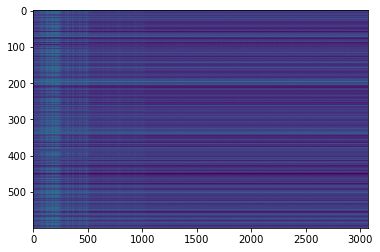

AUC      pAUC
Source_0  0.701300  0.546316
Source_1  0.724900  0.550000
Source_2  0.514100  0.527895
Target_0  0.767800  0.606842
Target_1  0.576700  0.509474
Target_2  0.399400  0.485263
mean      0.614033  0.537632
h_mean    0.583048  0.535028

2021-05-21 23:32:23,922 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:980.065140, val_AUC_hmean:0.583048, val_pAUC_hmean:0.535028, best_flag:True
2021-05-21 23:32:23,923 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.42it/s]
2021-05-21 23:32:24,416 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:32:24,631 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


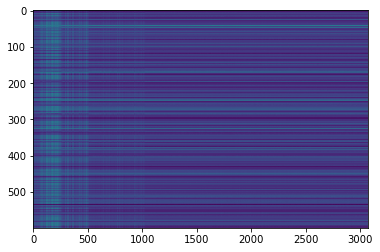

AUC      pAUC
Source_0  0.649500  0.566316
Source_1  0.745900  0.555263
Source_2  0.614700  0.523684
Target_0  0.741100  0.597368
Target_1  0.680500  0.530000
Target_2  0.462900  0.488947
mean      0.649100  0.543596
h_mean    0.632493  0.541404

2021-05-21 23:32:25,815 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:953.021530, val_AUC_hmean:0.632493, val_pAUC_hmean:0.541404, best_flag:True
2021-05-21 23:32:25,816 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-05-21 23:32:26,280 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-21 23:32:26,500 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:32:26,709 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:930.542847, val_AUC_hmean:0.621829, val_pAUC_hmean:0.527333, best_flag:False
2021-05-21 23:32:26,710 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.52it/s]
2021-05-21 23:32:27,203 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.11it/s]
2021-05-21 23:32:27,412 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.49it/s]
2021-05-21 23:32:

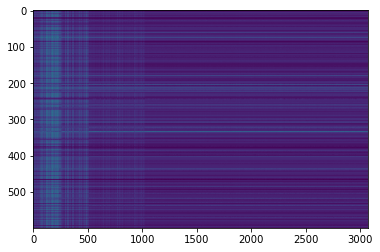

AUC      pAUC
Source_0  0.664400  0.568421
Source_1  0.773400  0.585263
Source_2  0.493800  0.532632
Target_0  0.767700  0.600000
Target_1  0.613400  0.514737
Target_2  0.492300  0.497368
mean      0.634167  0.549737
h_mean    0.613036  0.547178

2021-05-21 23:32:30,347 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:859.669154, val_AUC_hmean:0.613036, val_pAUC_hmean:0.547178, best_flag:True
2021-05-21 23:32:30,348 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.25it/s]
2021-05-21 23:32:30,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.40it/s]
2021-05-21 23:32:31,110 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-21 23:32:31,328 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:836.923060, val_AUC_hmean:0.627740, val_pAUC_hmean:0.536469, best_flag:False
2021-05-21 23:32:31,329 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.47it/s]
2021-05-21 23:32:31,802 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-21 23:32:32,007 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-21 23:32:

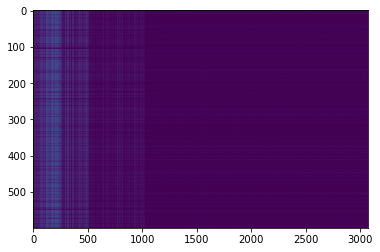

AUC      pAUC
Source_0  0.670500  0.529474
Source_1  0.765600  0.582632
Source_2  0.566300  0.533158
Target_0  0.766600  0.594737
Target_1  0.645600  0.563158
Target_2  0.525600  0.511579
mean      0.656700  0.552456
h_mean    0.643816  0.550838

2021-05-21 23:32:43,776 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:658.398448, val_AUC_hmean:0.643816, val_pAUC_hmean:0.550838, best_flag:True
2021-05-21 23:32:43,777 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.61it/s]
2021-05-21 23:32:44,287 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-21 23:32:44,502 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-21 23:32:44,730 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:643.608378, val_AUC_hmean:0.624217, val_pAUC_hmean:0.539723, best_flag:False
2021-05-21 23:32:44,732 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-05-21 23:32:45,192 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-21 23:32:45,408 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


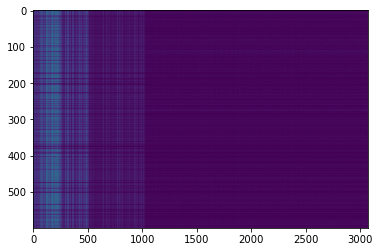

AUC      pAUC
Source_0  0.585300  0.535789
Source_1  0.755100  0.622105
Source_2  0.669000  0.513684
Target_0  0.720500  0.606316
Target_1  0.685400  0.561579
Target_2  0.547500  0.522105
mean      0.660467  0.560263
h_mean    0.652101  0.557316

2021-05-21 23:32:46,500 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:629.878255, val_AUC_hmean:0.652101, val_pAUC_hmean:0.557316, best_flag:True
2021-05-21 23:32:46,501 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.21it/s]
2021-05-21 23:32:47,020 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]
2021-05-21 23:32:47,246 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.48it/s]
2021-05-21 23:32:47,482 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:616.649068, val_AUC_hmean:0.658171, val_pAUC_hmean:0.555176, best_flag:False
2021-05-21 23:32:47,484 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.95it/s]
2021-05-21 23:32:47,948 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-21 23:32:48,158 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


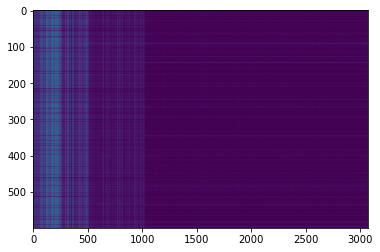

AUC      pAUC
Source_0  0.613600  0.549474
Source_1  0.764900  0.633158
Source_2  0.706500  0.535789
Target_0  0.721600  0.592105
Target_1  0.692000  0.581053
Target_2  0.533200  0.520526
mean      0.671967  0.568684
h_mean    0.662334  0.566211

2021-05-21 23:32:49,347 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:605.384857, val_AUC_hmean:0.662334, val_pAUC_hmean:0.566211, best_flag:True
2021-05-21 23:32:49,348 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.35it/s]
2021-05-21 23:32:49,864 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-21 23:32:50,065 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


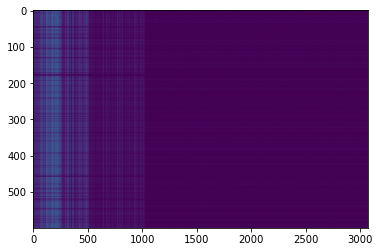

AUC      pAUC
Source_0  0.621100  0.544737
Source_1  0.773400  0.646842
Source_2  0.742600  0.632105
Target_0  0.665300  0.585263
Target_1  0.707800  0.553158
Target_2  0.571900  0.503158
mean      0.680350  0.577544
h_mean    0.673089  0.573196

2021-05-21 23:32:51,178 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:594.626628, val_AUC_hmean:0.673089, val_pAUC_hmean:0.573196, best_flag:True
2021-05-21 23:32:51,179 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.38it/s]
2021-05-21 23:32:51,673 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.45it/s]
2021-05-21 23:32:51,889 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:32:52,090 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:582.645223, val_AUC_hmean:0.665340, val_pAUC_hmean:0.572779, best_flag:False
2021-05-21 23:32:52,091 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.13it/s]
2021-05-21 23:32:52,535 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-21 23:32:52,754 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.54it/s]
2021-05-21 23:32:

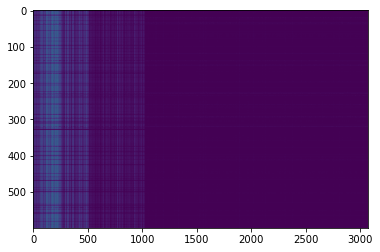

AUC      pAUC
Source_0  0.596600  0.529474
Source_1  0.767000  0.726842
Source_2  0.714300  0.588947
Target_0  0.678900  0.593684
Target_1  0.701700  0.547368
Target_2  0.581000  0.518421
mean      0.673250  0.584123
h_mean    0.666728  0.576774

2021-05-21 23:32:54,617 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:560.176890, val_AUC_hmean:0.666728, val_pAUC_hmean:0.576774, best_flag:True
2021-05-21 23:32:54,618 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.38it/s]
2021-05-21 23:32:55,075 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:32:55,286 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:32:55,490 - pytorch_modeler.py - INFO - epoch:36/300, train_losses:550.328069, val_AUC_hmean:0.673878, val_pAUC_hmean:0.574660, best_flag:False
2021-05-21 23:32:55,491 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.37it/s]
2021-05-21 23:32:55,967 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.40it/s]
2021-05-21 23:32:56,165 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:32:

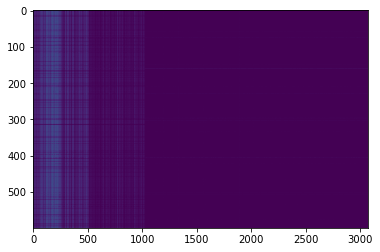

AUC      pAUC
Source_0  0.622100  0.541579
Source_1  0.779500  0.721579
Source_2  0.667200  0.559474
Target_0  0.705000  0.606316
Target_1  0.721500  0.561053
Target_2  0.551700  0.521579
mean      0.674500  0.585263
h_mean    0.666211  0.578669

2021-05-21 23:32:59,028 - pytorch_modeler.py - INFO - epoch:39/300, train_losses:520.805567, val_AUC_hmean:0.666211, val_pAUC_hmean:0.578669, best_flag:True
2021-05-21 23:32:59,029 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.29it/s]
2021-05-21 23:32:59,487 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:32:59,705 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:32:59,920 - pytorch_modeler.py - INFO - epoch:40/300, train_losses:511.341278, val_AUC_hmean:0.664779, val_pAUC_hmean:0.577254, best_flag:False
2021-05-21 23:32:59,921 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.10it/s]
2021-05-21 23:33:00,367 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:33:00,571 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.62it/s]


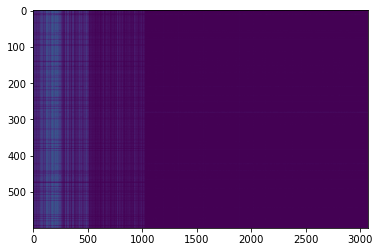

AUC      pAUC
Source_0  0.587700  0.537895
Source_1  0.791200  0.691579
Source_2  0.672600  0.579474
Target_0  0.692500  0.603158
Target_1  0.711900  0.565789
Target_2  0.573000  0.533158
mean      0.671483  0.585175
h_mean    0.663265  0.580733

2021-05-21 23:33:01,570 - pytorch_modeler.py - INFO - epoch:41/300, train_losses:501.474688, val_AUC_hmean:0.663265, val_pAUC_hmean:0.580733, best_flag:True
2021-05-21 23:33:01,571 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.96it/s]
2021-05-21 23:33:02,035 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
2021-05-21 23:33:02,249 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.36it/s]
2021-05-21 23:33:02,499 - pytorch_modeler.py - INFO - epoch:42/300, train_losses:491.907094, val_AUC_hmean:0.643943, val_pAUC_hmean:0.568025, best_flag:False
2021-05-21 23:33:02,501 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.98it/s]
2021-05-21 23:33:03,005 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 23:33:03,218 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
2021-05-21 23:33:

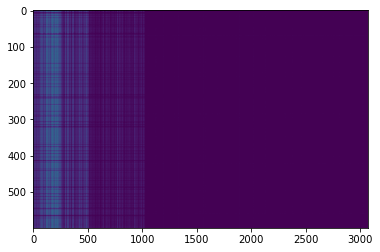

AUC      pAUC
Source_0  0.613600  0.537895
Source_1  0.807500  0.707895
Source_2  0.671500  0.594737
Target_0  0.710800  0.602105
Target_1  0.688700  0.569474
Target_2  0.545100  0.513158
mean      0.672867  0.587544
h_mean    0.662931  0.581467

2021-05-21 23:33:15,586 - pytorch_modeler.py - INFO - epoch:55/300, train_losses:387.099136, val_AUC_hmean:0.662931, val_pAUC_hmean:0.581467, best_flag:True
2021-05-21 23:33:15,587 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.55it/s]
2021-05-21 23:33:16,099 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-21 23:33:16,315 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.21it/s]
2021-05-21 23:33:16,558 - pytorch_modeler.py - INFO - epoch:56/300, train_losses:380.075874, val_AUC_hmean:0.635819, val_pAUC_hmean:0.546174, best_flag:False
2021-05-21 23:33:16,559 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.76it/s]
2021-05-21 23:33:17,066 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-21 23:33:17,287 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-21 23:33:

100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-21 23:33:30,976 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-21 23:33:31,183 - pytorch_modeler.py - INFO - epoch:72/300, train_losses:282.201421, val_AUC_hmean:0.653383, val_pAUC_hmean:0.561759, best_flag:False
2021-05-21 23:33:31,184 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.65it/s]
2021-05-21 23:33:31,637 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:33:31,845 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.31it/s]
2021-05-21 23:33:32,088 - pytorch_modeler.py - INFO - epoch:73/300, train_losses:293.156385, val_AUC_hmean:0.598408, val_pAUC_hmean:0.525721, best_flag:False
2021-05-21 23:33:32,089 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.54it/s]
2021-05-21 23:33:32,625 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.70it/s]
2021-05-21 23:33:46,846 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-21 23:33:47,052 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-21 23:33:47,258 - pytorch_modeler.py - INFO - epoch:89/300, train_losses:206.106386, val_AUC_hmean:0.671957, val_pAUC_hmean:0.578036, best_flag:False
2021-05-21 23:33:47,259 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-05-21 23:33:47,709 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-21 23:33:47,918 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:33:48,123 - pytorch_modeler.py - INFO - epoch:90/300, train_losses:201.778758, val_AUC_hmean:0.671641, val_pAUC_hmean:0.575708, best_flag:False
2021-05-21 23:33:48,124 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:34:01,934 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.33it/s]
2021-05-21 23:34:02,429 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:34:02,634 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.17it/s]
2021-05-21 23:34:02,858 - pytorch_modeler.py - INFO - epoch:106/300, train_losses:148.754597, val_AUC_hmean:0.680500, val_pAUC_hmean:0.575188, best_flag:False
2021-05-21 23:34:02,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.86it/s]
2021-05-21 23:34:03,344 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.48it/s]
2021-05-21 23:34:03,558 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
2021-05-21 23:34:03,774 - pytorch_modeler.py - INFO - epoch:107/300, train_losses:145.510867, val_AUC_hmean:0.673698, val_pAUC_hmean:0.577849, best_flag:False
2021-05-21 23:

100%|██████████| 2/2 [00:00<00:00,  9.05it/s]
2021-05-21 23:34:18,006 - pytorch_modeler.py - INFO - epoch:122/300, train_losses:109.853109, val_AUC_hmean:0.651898, val_pAUC_hmean:0.574874, best_flag:False
2021-05-21 23:34:18,007 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.00it/s]
2021-05-21 23:34:18,489 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.04it/s]
2021-05-21 23:34:18,734 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
2021-05-21 23:34:18,968 - pytorch_modeler.py - INFO - epoch:123/300, train_losses:116.268756, val_AUC_hmean:0.565819, val_pAUC_hmean:0.517407, best_flag:False
2021-05-21 23:34:18,970 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.43it/s]
2021-05-21 23:34:19,591 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.32it/s]
2021-05-21 23:34:19,830 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 12/12 [00:00<00:00, 26.90it/s]
2021-05-21 23:34:34,484 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.99it/s]
2021-05-21 23:34:34,730 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-21 23:34:34,956 - pytorch_modeler.py - INFO - epoch:139/300, train_losses:79.435644, val_AUC_hmean:0.638011, val_pAUC_hmean:0.562216, best_flag:False
2021-05-21 23:34:34,957 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.23it/s]
2021-05-21 23:34:35,417 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:34:35,622 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
2021-05-21 23:34:35,849 - pytorch_modeler.py - INFO - epoch:140/300, train_losses:77.685628, val_AUC_hmean:0.648829, val_pAUC_hmean:0.571536, best_flag:False
2021-05-21 23:34:35,850 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:34:49,246 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.55it/s]
2021-05-21 23:34:49,700 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:34:49,916 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-21 23:34:50,121 - pytorch_modeler.py - INFO - epoch:156/300, train_losses:57.017563, val_AUC_hmean:0.642669, val_pAUC_hmean:0.557006, best_flag:False
2021-05-21 23:34:50,122 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.27it/s]
2021-05-21 23:34:50,565 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
2021-05-21 23:34:50,764 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-21 23:34:50,968 - pytorch_modeler.py - INFO - epoch:157/300, train_losses:56.214391, val_AUC_hmean:0.643884, val_pAUC_hmean:0.563906, best_flag:False
2021-05-21 23:34

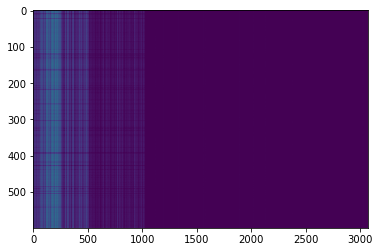

AUC      pAUC
Source_0  0.590400  0.534211
Source_1  0.786700  0.716842
Source_2  0.689200  0.602105
Target_0  0.656000  0.582632
Target_1  0.700200  0.601053
Target_2  0.564100  0.514737
mean      0.664433  0.591930
h_mean    0.656373  0.585331

2021-05-21 23:34:56,364 - pytorch_modeler.py - INFO - epoch:162/300, train_losses:49.638148, val_AUC_hmean:0.656373, val_pAUC_hmean:0.585331, best_flag:True
2021-05-21 23:34:56,365 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.98it/s]
2021-05-21 23:34:56,831 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
2021-05-21 23:34:57,053 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:34:57,262 - pytorch_modeler.py - INFO - epoch:163/300, train_losses:49.034034, val_AUC_hmean:0.652456, val_pAUC_hmean:0.577989, best_flag:False
2021-05-21 23:34:57,263 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:34:57,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.95it/s]
2021-05-21 23:34:57,968 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-21 23:34:

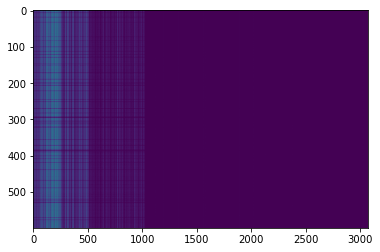

AUC      pAUC
Source_0  0.520000  0.548421
Source_1  0.803800  0.724737
Source_2  0.735900  0.591053
Target_0  0.606700  0.586842
Target_1  0.703500  0.572105
Target_2  0.575500  0.528947
mean      0.657567  0.592018
h_mean    0.642853  0.586073

2021-05-21 23:35:04,457 - pytorch_modeler.py - INFO - epoch:170/300, train_losses:41.794670, val_AUC_hmean:0.642853, val_pAUC_hmean:0.586073, best_flag:True
2021-05-21 23:35:04,458 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.51it/s]
2021-05-21 23:35:04,950 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-21 23:35:05,172 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-21 23:35:05,399 - pytorch_modeler.py - INFO - epoch:171/300, train_losses:41.640737, val_AUC_hmean:0.638047, val_pAUC_hmean:0.578357, best_flag:False
2021-05-21 23:35:05,400 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.19it/s]
2021-05-21 23:35:05,879 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.31it/s]
2021-05-21 23:35:06,118 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.95it/s]
2021-05-21 23:35:

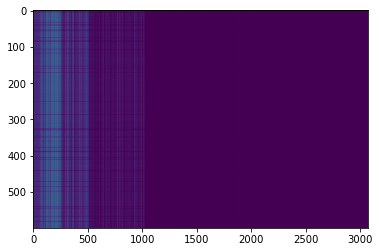

AUC      pAUC
Source_0  0.578800  0.543158
Source_1  0.785100  0.735263
Source_2  0.617500  0.608947
Target_0  0.672100  0.581579
Target_1  0.689500  0.580000
Target_2  0.551100  0.522632
mean      0.649017  0.595263
h_mean    0.640094  0.588217

2021-05-21 23:35:11,354 - pytorch_modeler.py - INFO - epoch:176/300, train_losses:37.386371, val_AUC_hmean:0.640094, val_pAUC_hmean:0.588217, best_flag:True
2021-05-21 23:35:11,355 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.22it/s]
2021-05-21 23:35:11,874 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
2021-05-21 23:35:12,086 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.45it/s]
2021-05-21 23:35:12,308 - pytorch_modeler.py - INFO - epoch:177/300, train_losses:35.998459, val_AUC_hmean:0.651717, val_pAUC_hmean:0.585568, best_flag:False
2021-05-21 23:35:12,309 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.53it/s]
2021-05-21 23:35:12,782 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-21 23:35:12,994 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-21 23:35:

100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:35:26,881 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
2021-05-21 23:35:27,095 - pytorch_modeler.py - INFO - epoch:193/300, train_losses:26.751292, val_AUC_hmean:0.634858, val_pAUC_hmean:0.579967, best_flag:False
2021-05-21 23:35:27,096 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.40it/s]
2021-05-21 23:35:27,553 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
2021-05-21 23:35:27,768 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:35:27,973 - pytorch_modeler.py - INFO - epoch:194/300, train_losses:26.702139, val_AUC_hmean:0.648980, val_pAUC_hmean:0.580930, best_flag:False
2021-05-21 23:35:27,975 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.38it/s]
2021-05-21 23:35:28,432 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.95it/s]
2021-05-21 23:35:41,658 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-21 23:35:41,867 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:35:42,073 - pytorch_modeler.py - INFO - epoch:210/300, train_losses:18.201182, val_AUC_hmean:0.643645, val_pAUC_hmean:0.571035, best_flag:False
2021-05-21 23:35:42,074 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.77it/s]
2021-05-21 23:35:42,525 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-21 23:35:42,743 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:35:42,954 - pytorch_modeler.py - INFO - epoch:211/300, train_losses:17.892709, val_AUC_hmean:0.645303, val_pAUC_hmean:0.576206, best_flag:False
2021-05-21 23:35:42,956 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:35:56,532 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.92it/s]
2021-05-21 23:35:57,016 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-21 23:35:57,226 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-21 23:35:57,430 - pytorch_modeler.py - INFO - epoch:227/300, train_losses:12.067250, val_AUC_hmean:0.656213, val_pAUC_hmean:0.585105, best_flag:False
2021-05-21 23:35:57,431 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.78it/s]
2021-05-21 23:35:57,881 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-21 23:35:58,087 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:35:58,291 - pytorch_modeler.py - INFO - epoch:228/300, train_losses:12.089515, val_AUC_hmean:0.645479, val_pAUC_hmean:0.574798, best_flag:False
2021-05-21 23:35

100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-21 23:36:12,188 - pytorch_modeler.py - INFO - epoch:243/300, train_losses:9.823199, val_AUC_hmean:0.628232, val_pAUC_hmean:0.558540, best_flag:False
2021-05-21 23:36:12,189 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.54it/s]
2021-05-21 23:36:12,681 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
2021-05-21 23:36:12,892 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:36:13,101 - pytorch_modeler.py - INFO - epoch:244/300, train_losses:9.075206, val_AUC_hmean:0.646102, val_pAUC_hmean:0.565017, best_flag:False
2021-05-21 23:36:13,102 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.61it/s]
2021-05-21 23:36:13,557 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.77it/s]
2021-05-21 23:36:13,782 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2

100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-21 23:36:28,019 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-21 23:36:28,240 - pytorch_modeler.py - INFO - epoch:260/300, train_losses:6.209934, val_AUC_hmean:0.643652, val_pAUC_hmean:0.576289, best_flag:False
2021-05-21 23:36:28,241 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.43it/s]
2021-05-21 23:36:28,716 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-21 23:36:28,939 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
2021-05-21 23:36:29,180 - pytorch_modeler.py - INFO - epoch:261/300, train_losses:6.034231, val_AUC_hmean:0.639982, val_pAUC_hmean:0.573408, best_flag:False
2021-05-21 23:36:29,182 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.92it/s]
2021-05-21 23:36:29,648 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

100%|██████████| 12/12 [00:00<00:00, 26.61it/s]
2021-05-21 23:36:43,691 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.09it/s]
2021-05-21 23:36:43,910 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:36:44,121 - pytorch_modeler.py - INFO - epoch:277/300, train_losses:4.676118, val_AUC_hmean:0.643110, val_pAUC_hmean:0.579093, best_flag:False
2021-05-21 23:36:44,122 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.76it/s]
2021-05-21 23:36:44,573 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-21 23:36:44,782 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.81it/s]
2021-05-21 23:36:44,994 - pytorch_modeler.py - INFO - epoch:278/300, train_losses:4.535892, val_AUC_hmean:0.639124, val_pAUC_hmean:0.574315, best_flag:False
2021-05-21 23:36:44,996 - pytorch_modeler.py - INFO - train
100%|██████████| 1

2021-05-21 23:36:59,144 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.15it/s]
2021-05-21 23:36:59,742 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.68it/s]
2021-05-21 23:36:59,971 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-21 23:37:00,192 - pytorch_modeler.py - INFO - epoch:294/300, train_losses:3.476214, val_AUC_hmean:0.612476, val_pAUC_hmean:0.560508, best_flag:False
2021-05-21 23:37:00,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.65it/s]
2021-05-21 23:37:00,806 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-21 23:37:01,019 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-21 23:37:01,234 - pytorch_modeler.py - INFO - epoch:295/300, train_losses:24.335595, val_AUC_hmean:0.533580, val_pAUC_hmean:0.541081, best_flag:False
2021-05-21 23:37:

AUC      pAUC
Source_0  0.578800  0.543158
Source_1  0.785100  0.735263
Source_2  0.617500  0.608947
Target_0  0.672100  0.581579
Target_1  0.689500  0.580000
Target_2  0.551100  0.522632
mean      0.649017  0.595263
h_mean    0.640094  0.588217

2021-05-21 23:37:06,132 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-05-21 23:37:06,133 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 296.139053583 [sec]


2021-05-21 23:37:06,652 - 00_train.py - INFO - TRAINING
2021-05-21 23:37:06,895 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 18.29it/s]
2021-05-21 23:37:07,554 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.64it/s]
2021-05-21 23:37:07,784 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


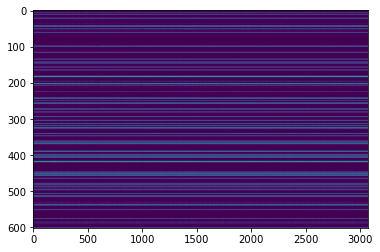

AUC      pAUC
Source_0  0.474800  0.493158
Source_1  0.485200  0.502632
Source_2  0.291889  0.501360
Target_0  0.545000  0.494737
Target_1  0.532449  0.513426
Target_2  0.520473  0.489973
mean      0.474969  0.499214
h_mean    0.453603  0.499095

2021-05-21 23:37:08,927 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:1894.154144, val_AUC_hmean:0.453603, val_pAUC_hmean:0.499095, best_flag:True
2021-05-21 23:37:08,928 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.78it/s]
2021-05-21 23:37:09,435 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.39it/s]
2021-05-21 23:37:09,695 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


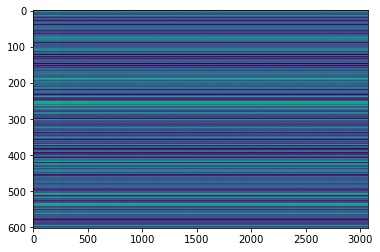

AUC      pAUC
Source_0  0.419900  0.494211
Source_1  0.495600  0.503684
Source_2  0.548128  0.548738
Target_0  0.532500  0.490000
Target_1  0.551735  0.516864
Target_2  0.584679  0.549869
mean      0.522090  0.517228
h_mean    0.516155  0.516114

2021-05-21 23:37:10,824 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:1349.192749, val_AUC_hmean:0.516155, val_pAUC_hmean:0.516114, best_flag:True
2021-05-21 23:37:10,825 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.80it/s]
2021-05-21 23:37:11,311 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-21 23:37:11,525 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


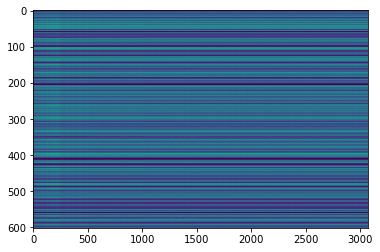

AUC      pAUC
Source_0  0.391100  0.481053
Source_1  0.580100  0.546842
Source_2  0.651783  0.522000
Target_0  0.571500  0.517368
Target_1  0.571122  0.514930
Target_2  0.602749  0.545418
mean      0.561392  0.521269
h_mean    0.546708  0.520314

2021-05-21 23:37:12,693 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:1218.443492, val_AUC_hmean:0.546708, val_pAUC_hmean:0.520314, best_flag:True
2021-05-21 23:37:12,693 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.06it/s]
2021-05-21 23:37:13,174 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:37:13,374 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


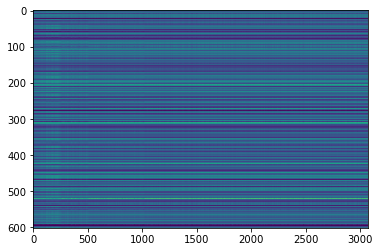

AUC      pAUC
Source_0  0.565200  0.485263
Source_1  0.846700  0.644737
Source_2  0.746435  0.582043
Target_0  0.527000  0.508947
Target_1  0.666327  0.538024
Target_2  0.642637  0.640118
mean      0.665716  0.566522
h_mean    0.649040  0.559934

2021-05-21 23:37:14,380 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:1133.570516, val_AUC_hmean:0.649040, val_pAUC_hmean:0.559934, best_flag:True
2021-05-21 23:37:14,381 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.52it/s]
2021-05-21 23:37:14,854 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-21 23:37:15,060 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


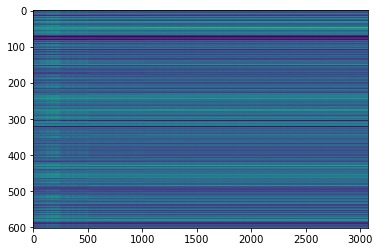

AUC      pAUC
Source_0  0.526800  0.508421
Source_1  0.865300  0.694211
Source_2  0.761765  0.590018
Target_0  0.488700  0.510526
Target_1  0.690816  0.563588
Target_2  0.596405  0.592768
mean      0.654964  0.576589
h_mean    0.629117  0.570216

2021-05-21 23:37:16,037 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:1072.049937, val_AUC_hmean:0.629117, val_pAUC_hmean:0.570216, best_flag:True
2021-05-21 23:37:16,038 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.51it/s]
2021-05-21 23:37:16,492 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:37:16,697 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:37:16,896 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:1023.609701, val_AUC_hmean:0.601505, val_pAUC_hmean:0.564894, best_flag:False
2021-05-21 23:37:16,897 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.70it/s]
2021-05-21 23:37:17,349 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-21 23:37:17,558 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
2021-05-21 23:37:

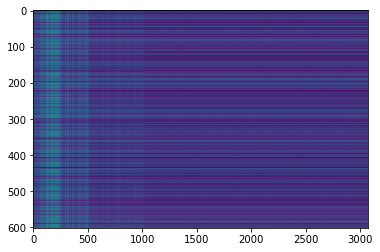

AUC      pAUC
Source_0  0.661700  0.520526
Source_1  0.886000  0.743684
Source_2  0.747683  0.694155
Target_0  0.461100  0.494211
Target_1  0.610714  0.516434
Target_2  0.565840  0.543091
mean      0.655506  0.585350
h_mean    0.628218  0.571021

2021-05-21 23:37:22,882 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:855.878688, val_AUC_hmean:0.628218, val_pAUC_hmean:0.571021, best_flag:True
2021-05-21 23:37:22,883 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.52it/s]
2021-05-21 23:37:23,356 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.43it/s]
2021-05-21 23:37:23,593 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.76it/s]
2021-05-21 23:37:23,827 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:835.769058, val_AUC_hmean:0.618979, val_pAUC_hmean:0.554186, best_flag:False
2021-05-21 23:37:23,828 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.82it/s]
2021-05-21 23:37:24,314 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-21 23:37:24,537 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-21 23:37:

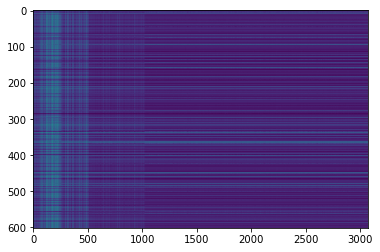

AUC      pAUC
Source_0  0.657800  0.546842
Source_1  0.858500  0.735263
Source_2  0.738324  0.672577
Target_0  0.481000  0.495263
Target_1  0.592551  0.510097
Target_2  0.557574  0.551185
mean      0.647625  0.585205
h_mean    0.625028  0.573100

2021-05-21 23:37:27,358 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:778.122589, val_AUC_hmean:0.625028, val_pAUC_hmean:0.573100, best_flag:True
2021-05-21 23:37:27,359 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.70it/s]
2021-05-21 23:37:27,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-21 23:37:28,117 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.24it/s]
2021-05-21 23:37:28,364 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:759.145142, val_AUC_hmean:0.626452, val_pAUC_hmean:0.558829, best_flag:False
2021-05-21 23:37:28,365 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.10it/s]
2021-05-21 23:37:28,865 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.72it/s]
2021-05-21 23:37:29,095 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.51it/s]


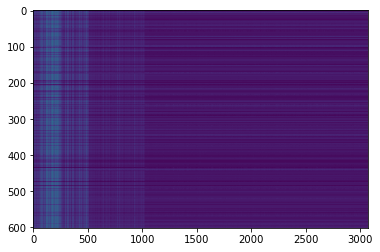

AUC      pAUC
Source_0  0.711400  0.552632
Source_1  0.913600  0.797895
Source_2  0.803476  0.720424
Target_0  0.486800  0.499474
Target_1  0.607449  0.506015
Target_2  0.580642  0.560392
mean      0.683894  0.606138
h_mean    0.654484  0.587447

2021-05-21 23:37:30,328 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:744.293757, val_AUC_hmean:0.654484, val_pAUC_hmean:0.587447, best_flag:True
2021-05-21 23:37:30,329 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.86it/s]
2021-05-21 23:37:30,856 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-21 23:37:31,064 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:37:31,276 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:726.436976, val_AUC_hmean:0.644283, val_pAUC_hmean:0.571756, best_flag:False
2021-05-21 23:37:31,277 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.89it/s]
2021-05-21 23:37:31,763 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-21 23:37:31,978 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-21 23:37:

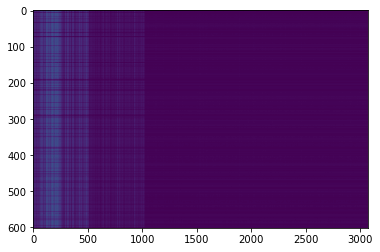

AUC      pAUC
Source_0  0.762800  0.580000
Source_1  0.896000  0.785789
Source_2  0.809358  0.757013
Target_0  0.473300  0.493684
Target_1  0.609388  0.497852
Target_2  0.591792  0.541775
mean      0.690440  0.609352
h_mean    0.658893  0.588367

2021-05-21 23:37:42,520 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:582.086314, val_AUC_hmean:0.658893, val_pAUC_hmean:0.588367, best_flag:True
2021-05-21 23:37:42,521 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.56it/s]
2021-05-21 23:37:43,013 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-21 23:37:43,211 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-21 23:37:43,425 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:569.977392, val_AUC_hmean:0.629071, val_pAUC_hmean:0.556714, best_flag:False
2021-05-21 23:37:43,426 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.98it/s]
2021-05-21 23:37:43,873 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:37:44,081 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-21 23:37:

100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-21 23:37:57,452 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:37:57,657 - pytorch_modeler.py - INFO - epoch:47/300, train_losses:419.502886, val_AUC_hmean:0.652480, val_pAUC_hmean:0.577010, best_flag:False
2021-05-21 23:37:57,658 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.20it/s]
2021-05-21 23:37:58,119 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-21 23:37:58,323 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:37:58,537 - pytorch_modeler.py - INFO - epoch:48/300, train_losses:412.256048, val_AUC_hmean:0.640456, val_pAUC_hmean:0.575187, best_flag:False
2021-05-21 23:37:58,538 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.21it/s]
2021-05-21 23:37:58,999 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 27.16it/s]
2021-05-21 23:38:12,521 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-21 23:38:12,722 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-21 23:38:12,937 - pytorch_modeler.py - INFO - epoch:64/300, train_losses:304.612536, val_AUC_hmean:0.642972, val_pAUC_hmean:0.569295, best_flag:False
2021-05-21 23:38:12,938 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.89it/s]
2021-05-21 23:38:13,386 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.34it/s]
2021-05-21 23:38:13,583 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:38:13,782 - pytorch_modeler.py - INFO - epoch:65/300, train_losses:299.444977, val_AUC_hmean:0.642060, val_pAUC_hmean:0.569060, best_flag:False
2021-05-21 23:38:13,783 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:38:27,678 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.51it/s]
2021-05-21 23:38:28,116 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.67it/s]
2021-05-21 23:38:28,345 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-21 23:38:28,557 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:221.273881, val_AUC_hmean:0.650620, val_pAUC_hmean:0.574430, best_flag:False
2021-05-21 23:38:28,558 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.42it/s]
2021-05-21 23:38:29,096 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-21 23:38:29,313 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
2021-05-21 23:38:29,536 - pytorch_modeler.py - INFO - epoch:82/300, train_losses:217.544281, val_AUC_hmean:0.650869, val_pAUC_hmean:0.579377, best_flag:False
2021-05-21 23:38

100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:38:43,232 - pytorch_modeler.py - INFO - epoch:97/300, train_losses:163.618596, val_AUC_hmean:0.654278, val_pAUC_hmean:0.580389, best_flag:False
2021-05-21 23:38:43,233 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.19it/s]
2021-05-21 23:38:43,694 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-21 23:38:43,913 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.82it/s]
2021-05-21 23:38:44,123 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:160.508527, val_AUC_hmean:0.665461, val_pAUC_hmean:0.574603, best_flag:False
2021-05-21 23:38:44,125 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.57it/s]
2021-05-21 23:38:44,616 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.64it/s]
2021-05-21 23:38:44,846 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

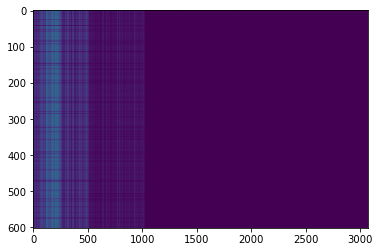

AUC      pAUC
Source_0  0.734600  0.564737
Source_1  0.885300  0.824211
Source_2  0.775223  0.749038
Target_0  0.481500  0.486842
Target_1  0.616735  0.515252
Target_2  0.560650  0.551792
mean      0.675668  0.615312
h_mean    0.647757  0.592523

2021-05-21 23:38:48,706 - pytorch_modeler.py - INFO - epoch:102/300, train_losses:149.456635, val_AUC_hmean:0.647757, val_pAUC_hmean:0.592523, best_flag:True
2021-05-21 23:38:48,707 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.98it/s]
2021-05-21 23:38:49,210 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.19it/s]
2021-05-21 23:38:49,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.60it/s]
2021-05-21 23:38:49,686 - pytorch_modeler.py - INFO - epoch:103/300, train_losses:150.160177, val_AUC_hmean:0.597277, val_pAUC_hmean:0.551714, best_flag:False
2021-05-21 23:38:49,687 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.51it/s]
2021-05-21 23:38:50,179 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-21 23:38:50,396 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
2021-05-21 23:3

100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-21 23:39:03,816 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-21 23:39:04,026 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:107.410952, val_AUC_hmean:0.661585, val_pAUC_hmean:0.581266, best_flag:False
2021-05-21 23:39:04,028 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.33it/s]
2021-05-21 23:39:04,486 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-21 23:39:04,701 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:39:04,904 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:105.597599, val_AUC_hmean:0.630834, val_pAUC_hmean:0.578061, best_flag:False
2021-05-21 23:39:04,905 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.74it/s]
2021-05-21 23:39:05,356 - pytorch_modeler.py - INFO - valid_source
100%|█████████

2021-05-21 23:39:18,235 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.14it/s]
2021-05-21 23:39:18,679 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.15it/s]
2021-05-21 23:39:18,877 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
2021-05-21 23:39:19,076 - pytorch_modeler.py - INFO - epoch:136/300, train_losses:76.834564, val_AUC_hmean:0.651492, val_pAUC_hmean:0.577944, best_flag:False
2021-05-21 23:39:19,076 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.93it/s]
2021-05-21 23:39:19,542 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-21 23:39:19,746 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
2021-05-21 23:39:19,949 - pytorch_modeler.py - INFO - epoch:137/300, train_losses:76.078775, val_AUC_hmean:0.641565, val_pAUC_hmean:0.577968, best_flag:False
2021-05-21 23:39

100%|██████████| 2/2 [00:00<00:00, 11.54it/s]
2021-05-21 23:39:32,518 - pytorch_modeler.py - INFO - epoch:152/300, train_losses:56.090089, val_AUC_hmean:0.647363, val_pAUC_hmean:0.581310, best_flag:False
2021-05-21 23:39:32,519 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.60it/s]
2021-05-21 23:39:32,956 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
2021-05-21 23:39:33,150 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.25it/s]
2021-05-21 23:39:33,349 - pytorch_modeler.py - INFO - epoch:153/300, train_losses:55.600118, val_AUC_hmean:0.631107, val_pAUC_hmean:0.577894, best_flag:False
2021-05-21 23:39:33,351 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.36it/s]
2021-05-21 23:39:33,792 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-21 23:39:34,006 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-21 23:39:47,209 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.85it/s]
2021-05-21 23:39:47,438 - pytorch_modeler.py - INFO - epoch:169/300, train_losses:39.891907, val_AUC_hmean:0.649756, val_pAUC_hmean:0.574758, best_flag:False
2021-05-21 23:39:47,439 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.23it/s]
2021-05-21 23:39:47,936 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-21 23:39:48,146 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-21 23:39:48,362 - pytorch_modeler.py - INFO - epoch:170/300, train_losses:39.718063, val_AUC_hmean:0.671843, val_pAUC_hmean:0.572109, best_flag:False
2021-05-21 23:39:48,363 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.86it/s]
2021-05-21 23:39:48,869 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 26.76it/s]
2021-05-21 23:40:02,189 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-21 23:40:02,386 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-21 23:40:02,597 - pytorch_modeler.py - INFO - epoch:186/300, train_losses:30.168535, val_AUC_hmean:0.646583, val_pAUC_hmean:0.551360, best_flag:False
2021-05-21 23:40:02,598 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.54it/s]
2021-05-21 23:40:03,052 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.43it/s]
2021-05-21 23:40:03,265 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.75it/s]
2021-05-21 23:40:03,476 - pytorch_modeler.py - INFO - epoch:187/300, train_losses:30.622547, val_AUC_hmean:0.592902, val_pAUC_hmean:0.562472, best_flag:False
2021-05-21 23:40:03,477 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-21 23:40:16,992 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.53it/s]
2021-05-21 23:40:17,465 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-21 23:40:17,686 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-21 23:40:17,912 - pytorch_modeler.py - INFO - epoch:203/300, train_losses:20.149870, val_AUC_hmean:0.665724, val_pAUC_hmean:0.574437, best_flag:False
2021-05-21 23:40:17,914 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.17it/s]
2021-05-21 23:40:18,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-21 23:40:18,580 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-21 23:40:18,786 - pytorch_modeler.py - INFO - epoch:204/300, train_losses:19.355905, val_AUC_hmean:0.671654, val_pAUC_hmean:0.575293, best_flag:False
2021-05-21 23:40

100%|██████████| 2/2 [00:00<00:00, 10.32it/s]
2021-05-21 23:40:32,310 - pytorch_modeler.py - INFO - epoch:219/300, train_losses:14.254955, val_AUC_hmean:0.654129, val_pAUC_hmean:0.576702, best_flag:False
2021-05-21 23:40:32,311 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.98it/s]
2021-05-21 23:40:32,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
2021-05-21 23:40:32,986 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-21 23:40:33,191 - pytorch_modeler.py - INFO - epoch:220/300, train_losses:14.129850, val_AUC_hmean:0.648036, val_pAUC_hmean:0.582502, best_flag:False
2021-05-21 23:40:33,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.38it/s]
2021-05-21 23:40:33,668 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.66it/s]
2021-05-21 23:40:33,896 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
2021-05-21 23:40:47,306 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-21 23:40:47,520 - pytorch_modeler.py - INFO - epoch:236/300, train_losses:10.332191, val_AUC_hmean:0.659276, val_pAUC_hmean:0.584405, best_flag:False
2021-05-21 23:40:47,521 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.92it/s]
2021-05-21 23:40:47,986 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-21 23:40:48,186 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
2021-05-21 23:40:48,416 - pytorch_modeler.py - INFO - epoch:237/300, train_losses:9.833194, val_AUC_hmean:0.666436, val_pAUC_hmean:0.585071, best_flag:False
2021-05-21 23:40:48,418 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.64it/s]
2021-05-21 23:40:48,889 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 

100%|██████████| 12/12 [00:00<00:00, 26.17it/s]
2021-05-21 23:41:02,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-21 23:41:02,852 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
2021-05-21 23:41:03,063 - pytorch_modeler.py - INFO - epoch:253/300, train_losses:7.205761, val_AUC_hmean:0.645946, val_pAUC_hmean:0.574663, best_flag:False
2021-05-21 23:41:03,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.86it/s]
2021-05-21 23:41:03,514 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
2021-05-21 23:41:03,743 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-21 23:41:03,963 - pytorch_modeler.py - INFO - epoch:254/300, train_losses:6.929430, val_AUC_hmean:0.659071, val_pAUC_hmean:0.578013, best_flag:False
2021-05-21 23:41:03,964 - pytorch_modeler.py - INFO - train
100%|██████████| 1

2021-05-21 23:41:16,869 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.74it/s]
2021-05-21 23:41:17,402 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.15it/s]
2021-05-21 23:41:17,619 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.11it/s]
2021-05-21 23:41:17,839 - pytorch_modeler.py - INFO - epoch:270/300, train_losses:5.293652, val_AUC_hmean:0.638912, val_pAUC_hmean:0.579747, best_flag:False
2021-05-21 23:41:17,841 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.78it/s]
2021-05-21 23:41:18,291 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-21 23:41:18,506 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.72it/s]
2021-05-21 23:41:18,736 - pytorch_modeler.py - INFO - epoch:271/300, train_losses:5.126086, val_AUC_hmean:0.657505, val_pAUC_hmean:0.575404, best_flag:False
2021-05-21 23:41:1

2021-05-21 23:41:32,163 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.80it/s]
2021-05-21 23:41:32,613 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-21 23:41:32,817 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-21 23:41:33,019 - pytorch_modeler.py - INFO - epoch:287/300, train_losses:3.649056, val_AUC_hmean:0.644109, val_pAUC_hmean:0.577311, best_flag:False
2021-05-21 23:41:33,020 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.90it/s]
2021-05-21 23:41:33,469 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-21 23:41:33,672 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-21 23:41:33,874 - pytorch_modeler.py - INFO - epoch:288/300, train_losses:3.352955, val_AUC_hmean:0.665846, val_pAUC_hmean:0.584654, best_flag:False
2021-05-21 23:41:3

AUC      pAUC
Source_0  0.734600  0.564737
Source_1  0.885300  0.824211
Source_2  0.775223  0.749038
Target_0  0.481500  0.486842
Target_1  0.616735  0.515252
Target_2  0.560650  0.551792
mean      0.675668  0.615312
h_mean    0.647757  0.592523

elapsed time: 278.525448084 [sec]


In [12]:
for machine_type in machine_types:
    run(machine_type)

In [13]:
#run(machine_types[4])